<a href="https://colab.research.google.com/github/hawa1983/DATA-612/blob/main/Project_4_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Purpose of Project 4**

The purpose of this project is to build, evaluate, and enhance a movie recommendation system using the MovieLens dataset. The project focuses on comparing two recommendation models:

1. **User-Based Collaborative Filtering (UBCF):** This model recommends movies based on the preferences of users with similar rating patterns. It is enhanced by incorporating user demographic features such as age, gender, and occupation.

2. **Content-Based Filtering (CBF):** This model recommends movies based on their genre similarity. It compares movies the user has liked with other movies using one-hot encoded genre vectors and cosine similarity.

To improve recommendation quality beyond basic accuracy, the project introduces three reranking strategies:

* **Diversity:** Encourages more varied recommendations by penalizing items that are too similar to others in the list.
* **Serendipity:** Favors items that are relevant but different from what the user has seen, aiming to provide pleasant surprises.
* **Novelty:** Promotes less popular movies to help users discover new and uncommon content.

The models and their reranked variants are evaluated using RMSE and MAE to measure accuracy. The project also includes detailed visual analyses of genre coverage, popularity effects, and agreement between models. These insights help assess the trade-offs between accuracy, variety, discovery, and personalization in recommendation systems.


## **Data Preparation**

**Methodology:**
We begin by working with a MovieLens-style dataset that includes user ratings, movie metadata (titles and genres), and user demographics. The goal is to prepare the data for both **collaborative filtering** and **content-based filtering**.

* For collaborative filtering, we construct a **User-Item Matrix**, where each cell represents a known rating by a user for a movie.
* For content-based filtering, we extract movie **genre labels**, perform **one-hot encoding**, and create **genre vectors**.
* For enhanced UBCF, we also prepare user demographic features (e.g., gender, age, occupation) to compute **demographic similarity**.

**Pseudo-Formulae:**

* **User-Item Matrix**

  $$
  \text{UserItem}[u, m] = \text{Rating of user } u \text{ for movie } m
  $$

* **Genre Vectors (One-Hot Encoded)**

  $$
  \text{GenreVector}[m] = [\text{Action}=1, \text{Drama}=0, \ldots]
  $$

* **User Demographic Vectors (One-Hot + Scaled)**

  $$
  \text{UserFeatures}[u] = \text{OneHot}(Gender, Occupation) + \text{Scaled}(Age)
  $$


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Load Data ---
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings.dat", sep="::", engine="python", names=["userId", "movieId", "rating", "timestamp"])
import pandas as pd

movies = pd.read_csv(
    "https://raw.githubusercontent.com/hawa1983/DATA-612/main/movies.dat",
    sep="::",
    engine="python",
    encoding="ISO-8859-1",
    names=["movieId", "title", "genres"]
)
users = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/users.dat", sep="::", engine="python", names=["userId", "gender", "age", "occupation", "zip"])

print("Ratings \n")
print(ratings.head())
print("Movies \n")
print(movies.head())
print("Users \n")
print(users.head())

# --- Merge Ratings with Users and Movies (Optional for analysis or hybrid features) ---
ratings_full = ratings.merge(users, on="userId").merge(movies, on="movieId")

# --- One-hot Encode Genres ---
movies["genres"] = movies["genres"].str.split("|")
mlb = MultiLabelBinarizer()
genre_dummies = pd.DataFrame(
    mlb.fit_transform(movies["genres"]),
    columns=mlb.classes_,
    index=movies["movieId"]
)

# --- Train-Test Split for Ratings ---
train_df, test_df = train_test_split(ratings, test_size=0.2, random_state=42)

# --- Create User-Item Matrix ---
user_item_matrix = train_df.pivot(index='userId', columns='movieId', values='rating').fillna(0)



Ratings 

   userId  movieId  rating  timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291
Movies 

   movieId                               title                        genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy
Users 

   userId gender  age  occupation    zip
0       1      F    1          10  48067
1       2      M   56          16  70072
2       3      M   25          15  55117
3       4      M   45           7  02460
4       5      M   25          20  55455


## **Collaborative Filtering Methods**

We used UBCF and CBF to evaluate the impact of Reranking strategies

### ***1. User-Based Collaborative Filtering (UBCF)***

**Methodology:**
UBCF recommends items by finding users with similar rating behavior. To improve recommendation quality, we enhance the similarity calculation by blending in **demographic similarity**.

**Pseudocode:**

1. Compute Rating-Based User Similarity
   - Input: User-Item Rating Matrix
   - Method: Cosine Similarity between users based on their rating vectors

2. Compute Demographic-Based User Similarity
   - Extract demographic features: gender, occupation, age
   - One-hot encode gender and occupation
   - Standardize age
   - Concatenate features to form demographic vectors
   - Compute Cosine Similarity between users based on demographic vectors

3. Combine Both Similarities
    - Define weight α (α = 0.9 for 90% emphasis on ratings)
    - Compute: CombinedSimilarity = α * RatingSimilarity + (1 - α) * DemographicSimilarity

4. Predict a User’s Rating for a Movie
   - If movie not rated by any similar users → return NaN
   - For each other user:
       If user rated the movie:

```
PredictedRating = Σ[sim(u,v) × r(v,m)] / Σ[sim(u,v)]
```

Where:

* `u` = target user
* `v` = other users who rated movie `m`
* `sim(u,v)` = similarity between user `u` and user `v`
* `r(v,m)` = rating given by user `v` to movie `m`


In [2]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import pickle

# --- Step 1: Compute Rating-Based Similarity ---
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# --- Step 2: Compute Demographic-Based Similarity ---
# Ensure userId is index-matched with user_item_matrix
users_filtered = users.set_index("userId").loc[user_item_matrix.index]

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False)
gender_occ_encoded = encoder.fit_transform(users_filtered[['gender', 'occupation']])

# Normalize numerical features
scaler = StandardScaler()
age_scaled = scaler.fit_transform(users_filtered[['age']])

# Combine features
user_features = np.hstack([gender_occ_encoded, age_scaled])

# Compute demographic similarity
demo_similarity = cosine_similarity(user_features)
demo_similarity_df = pd.DataFrame(demo_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# --- Step 3: Blend Similarities ---
alpha = 0.9  # weight for rating-based similarity
combined_similarity = alpha * user_similarity_df + (1 - alpha) * demo_similarity_df
combined_similarity_df = pd.DataFrame(combined_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# --- Step 4: Define Prediction Function Using Combined Similarity ---
def predict_ubcf(user_id, movie_id):
    if movie_id not in user_item_matrix.columns or user_id not in combined_similarity_df.index:
        return np.nan

    sims = combined_similarity_df.loc[user_id].values
    ratings = user_item_matrix[movie_id].values
    mask = ratings > 0

    if not np.any(mask):
        return np.nan

    numerator = np.dot(sims[mask], ratings[mask])
    denominator = sims[mask].sum()
    return numerator / denominator if denominator > 0 else np.nan

# --- Step 5: Save Combined Similarity Matrix ---
with open("combined_similarity_df.pkl", "wb") as f:
    pickle.dump(combined_similarity_df, f)

# Optional: Print sample
print(combined_similarity_df.iloc[:5, :7])


userId         1         2         3         4         5         6         7
userId                                                                      
1       1.000000 -0.022655  0.145491  0.019786  0.058190  0.123132  0.045572
2      -0.022655  1.000000  0.123580  0.192415  0.097653  0.156793  0.315099
3       0.145491  0.123580  1.000000  0.095511  0.083033  0.029408  0.138952
4       0.019786  0.192415  0.095511  1.000000  0.054477  0.045036  0.182761
5       0.058190  0.097653  0.083033  0.054477  1.000000  0.013558  0.132232


### ***2. Content-Based Filtering (CBF)***

**Methodology:**
CBF recommends items by comparing their **content features**, rather than relying on user-to-user similarity. In this case, we represent each movie by its **genre vector**, computed via one-hot encoding. We then use **cosine similarity** to identify movies similar in genre to those a user has already rated highly.

For any user and unseen movie, the system predicts how much the user will like it by looking at:

* How similar the movie is to those the user liked
* How highly the user rated those similar movies

**Pseudocode:**

i. Represent Movies by Genre Vectors

   * Input: Genre labels for each movie
   * Split genre strings into lists
   * One-hot encode genres
   * Output: Genre matrix (Movie × Genre)

ii. Compute Movie-to-Movie Similarity

   * Method: Cosine similarity between genre vectors
   * Output: Movie similarity matrix (Movie × Movie)

iii. Predict a User’s Rating for a Movie

   * For target user $u$ and movie $i$:

     * Get movies $j$ rated by $u$
     * Retrieve similarities $\text{sim}(i, j)$
     * Retrieve ratings $r(u, j)$
     * Compute:


```
PredictedRating = Σ[sim(i,j) × r(u,j)] / Σ[sim(i,j)]
```

Where:

* `i` = target movie
* `j` = movies the user `u` has already rated
* `sim(i,j)` = similarity between target movie `i` and movie `j`
* `r(u,j)` = rating user `u` gave to movie `j`


In [3]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import pickle

# --- Step 1: Prepare Genre Strings ---
# Ensure each genre list is a string (e.g., "Action Comedy Drama")
movies["genres"] = movies["genres"].apply(lambda x: x if isinstance(x, list) else [])
movies["genre_str"] = movies["genres"].apply(lambda g: " ".join(g))

# --- Step 2: TF-IDF Encoding of Genres ---
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(movies["genre_str"])

# --- Step 3: Compute Movie-to-Movie Similarity ---
movie_similarity = cosine_similarity(tfidf_matrix)
movie_similarity_df = pd.DataFrame(
    movie_similarity,
    index=movies["movieId"],
    columns=movies["movieId"]
)

# --- Step 4: Define TF-IDF-Based Content-Based Prediction Function ---
def predict_cbf(user_id, target_movie_id):
    if user_id not in user_item_matrix.index or target_movie_id not in movie_similarity_df.index:
        return np.nan

    user_ratings = user_item_matrix.loc[user_id]
    rated_movies = user_ratings[user_ratings > 0].index

    if len(rated_movies) == 0:
        return np.nan

    sims = movie_similarity_df.loc[target_movie_id, rated_movies].values
    ratings = user_ratings[rated_movies].values

    numerator = np.dot(sims, ratings)
    denominator = sims.sum()
    return numerator / denominator if denominator > 0 else np.nan

# --- Step 5: Save Movie Similarity Matrix ---
with open("movie_similarity_df.pkl", "wb") as f:
    pickle.dump(movie_similarity_df, f)

# --- Optional: Preview ---
print(movie_similarity_df.iloc[:5, :7])


movieId         1         2         3         4         5    6         7
movieId                                                                 
1        1.000000  0.305525  0.197372  0.260194  0.344351  0.0  0.197372
2        0.305525  1.000000  0.000000  0.000000  0.000000  0.0  0.000000
3        0.197372  0.000000  1.000000  0.433093  0.573172  0.0  1.000000
4        0.260194  0.000000  0.433093  1.000000  0.755606  0.0  0.433093
5        0.344351  0.000000  0.573172  0.755606  1.000000  0.0  0.573172


## **Model Evaluation Before Reranking**

**Methodology:**

Next we evaluate `UBCF` and `CBF` using RMSE and MAE on the test set as required by Project 4. These measure how close predicted ratings are to actual ratings.

Pseudo-Formulas:

```
RMSE = sqrt(mean((actual - predicted)^2))
MAE = mean(|actual - predicted|)
```

Evaluating CBF: 100%|██████████| 200042/200042 [04:14<00:00, 787.05it/s]


  Model      RMSE       MAE
0  UBCF  0.975643  0.779365
1   CBF  1.015399  0.811255


<Axes: title={'center': 'Model Evaluation'}, xlabel='Model'>

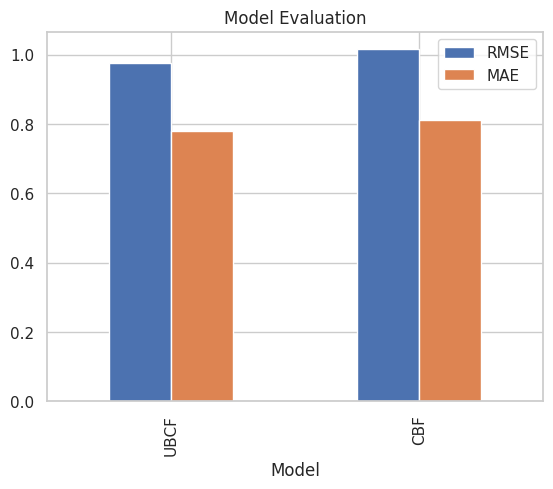

In [ ]:
from joblib import Parallel, delayed
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
from tqdm import tqdm

def evaluate_model_parallel(predict_fn, test_df, label, n_jobs=-1):
    def safe_predict(row):
        pred = predict_fn(row['userId'], row['movieId'])
        return (row['rating'], pred) if not np.isnan(pred) else None

    results = Parallel(n_jobs=n_jobs, prefer="threads")(
        delayed(safe_predict)(row) for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc=f"Evaluating {label}")
    )

    # Filter out failed predictions
    results = [r for r in results if r is not None]
    actuals, predictions = zip(*results) if results else ([], [])

    if not predictions:
        return {'Model': label, 'RMSE': np.nan, 'MAE': np.nan}

    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    return {'Model': label, 'RMSE': rmse, 'MAE': mae}

ubcf_eval = evaluate_model_parallel(predict_ubcf, test_df, "UBCF")
cbf_eval = evaluate_model_parallel(predict_cbf, test_df, "CBF")
metrics_df = pd.DataFrame([ubcf_eval, cbf_eval])

print(metrics_df)

metrics_df.plot(kind="bar", x="Model", y=["RMSE", "MAE"], title="Model Evaluation")


The bar chart compares model evaluation metrics—**RMSE** and **MAE**—for UBCF (User-Based Collaborative Filtering) and CBF (Content-Based Filtering).

**Observation:**

* **UBCF outperforms CBF** slightly, achieving lower RMSE and MAE values.

  * RMSE: UBCF ≈ 0.97 vs CBF ≈ 1.01
  * MAE: UBCF ≈ 0.78 vs CBF ≈ 0.81

**Conclusion:**
User-Based Collaborative Filtering yields more accurate predictions overall, suggesting it better captures user preferences than the content-based approach in this context.


## Generate Recommendations for All Users

In [4]:
import os
import pandas as pd
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
import pickle

# --- Active users only (speed optimization) ---
active_users = user_item_matrix[user_item_matrix.gt(0).sum(axis=1) >= 50]
all_user_ids = active_users.index.tolist()

# --- UBCF Vectorized Prediction ---
def predict_ubcf_batch(user_id, top_n=10):
    sims = combined_similarity_df.loc[user_id].values
    ratings_matrix = user_item_matrix.values
    movie_ids = user_item_matrix.columns

    weighted_sum = np.dot(sims, ratings_matrix)
    sim_sum = np.dot(sims, (ratings_matrix > 0).astype(float))

    scores = np.divide(weighted_sum, sim_sum, out=np.zeros_like(weighted_sum), where=sim_sum != 0)
    seen = user_item_matrix.loc[user_id].values > 0
    scores[seen] = -np.inf

    top_indices = np.argpartition(scores, -top_n)[-top_n:]
    top_sorted = top_indices[np.argsort(scores[top_indices])[::-1]]
    return user_id, list(zip(movie_ids[top_sorted], scores[top_sorted]))

# --- CBF Vectorized Prediction ---
def predict_cbf_batch(user_id, top_n=10):
    all_movie_ids = movie_similarity_df.index
    user_ratings = user_item_matrix.loc[user_id].reindex(all_movie_ids).fillna(0)
    rated = user_ratings[user_ratings > 0]
    if rated.empty:
        return user_id, []

    sim_matrix = movie_similarity_df.loc[:, rated.index].values
    weighted_sum = np.dot(sim_matrix, rated.values)
    sim_sum = sim_matrix.sum(axis=1)

    scores = np.divide(weighted_sum, sim_sum, out=np.zeros_like(weighted_sum), where=sim_sum != 0)
    seen_mask = user_ratings > 0
    scores[seen_mask.values] = -np.inf

    top_indices = np.argpartition(scores, -top_n)[-top_n:]
    top_sorted = top_indices[np.argsort(scores[top_indices])[::-1]]
    top_movie_ids = all_movie_ids[top_sorted]

    return user_id, list(zip(top_movie_ids, scores[top_sorted]))

# --- Dispatcher ---
def predict_for_user(user_id, model_type, top_n=10):
    if model_type == "ubcf":
        return predict_ubcf_batch(user_id, top_n)
    elif model_type == "cbf":
        return predict_cbf_batch(user_id, top_n)
    else:
        raise ValueError("Invalid model type")

# --- Parallel Engine ---
def parallel_recommendations(model_type, top_n=10, desc="Recommending"):
    results = {}
    with ProcessPoolExecutor() as executor:
        futures = {executor.submit(predict_for_user, uid, model_type, top_n): uid for uid in all_user_ids}
        for future in tqdm(as_completed(futures), total=len(futures), desc=desc):
            uid, recs = future.result()
            results[uid] = recs
    return results

# --- Conditional Load or Compute ---
cbf_file = "all_user_recs_cbf.pkl"
ubcf_file = "all_user_recs_ubcf.pkl"

if os.path.exists(cbf_file) and os.path.exists(ubcf_file):
    print("Loading CBF and UBCF recommendations from saved files...")
    with open(cbf_file, "rb") as f:
        cbf_recs = pickle.load(f)
    with open(ubcf_file, "rb") as f:
        ubcf_recs = pickle.load(f)
else:
    print("Computing CBF and UBCF recommendations...")
    cbf_recs = parallel_recommendations("cbf", top_n=10, desc="CBF Recommendations")
    ubcf_recs = parallel_recommendations("ubcf", top_n=10, desc="UBCF Recommendations")

    print("Saving recommendations to disk...")
    with open(cbf_file, "wb") as f:
        pickle.dump(cbf_recs, f)
    with open(ubcf_file, "wb") as f:
        pickle.dump(ubcf_recs, f)


Computing CBF and UBCF recommendations...


UBCF Recommendations: 100%|██████████| 3858/3858 [07:41<00:00,  8.36it/s]


Saving recommendations to disk...


## **Reranking Procedures**

### ***1. Personalized Top-N Recommendation Generation: Purpose and Methodology***

We will generate a tailored list of top-N movie recommendations for user_id=6040 by UBCF and CBF to estimates how much the user would like each unseen movie.

**Step-by-Step Methodology**

i. **Separate Seen from Unseen Movies**
   The system examines the user's rating history to identify which movies have already been rated. All remaining movies are considered unseen and thus eligible for recommendation.

ii. **Score Unseen Movies Using a Prediction Function**
   The prediction functions for content-based filtering (CBF) and user-based collaborative filtering (UBCF) — are applied to each unseen movie to estimate the user's likely rating.

iii. **Filter and Rank Predictions**
   The predicted scores are filtered to exclude missing values (NaN). The remaining scores are sorted in descending order to prioritize the highest recommendations.

iv. **Return Top-N Results**
   The top-N movie IDs with the highest predicted scores are selected as the final personalized recommendations.

**Prediction Logic (Pseudocode)**

```
For each movie m that user u has not rated:
    predicted_score = predict_fn(user u, movie m)

Keep predictions where predicted_score is valid
Sort all predicted movies by predicted_score in descending order
Return the top N results
```

This method provides a scalable way to evaluate any recommendation strategy, ensuring consistent performance evaluation across different models.


In [5]:
from joblib import Parallel, delayed
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
from tqdm import tqdm

def get_user_predictions(user_id, predict_fn, top_n=50):
    seen = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index
    unseen = user_item_matrix.columns.difference(seen)

    recs = []
    for mid in unseen:
        score = predict_fn(user_id, mid)
        if not np.isnan(score):
            recs.append((mid, score))

    return sorted(recs, key=lambda x: x[1], reverse=True)[:top_n]


# Generate and display top-50 movie recommendations for user 5549 using both UBCF and CBF
import random
# user_id = random.choice(user_item_matrix.index.tolist())

user_id = 5549

## --- UBCF Recommendations ---
top_recommendations_ubcf = get_user_predictions(user_id, predict_fn=predict_ubcf, top_n=50)
top_ubcf_df = pd.DataFrame(top_recommendations_ubcf, columns=['movieId', 'PredictedScore'])
print("Print the Top 10 UBCF Recommendations:")
print(top_ubcf_df.head(10))

## --- CBF Recommendations ---
top_recommendations_cbf = get_user_predictions(user_id, predict_fn=predict_cbf, top_n=50)
top_cbf_df = pd.DataFrame(top_recommendations_cbf, columns=['movieId', 'PredictedScore'])
print("\nPrint the Top 10 CBF Recommendations:")
print(top_cbf_df.head(10))



Print the Top 10 UBCF Recommendations:
   movieId  PredictedScore
0      643       13.589991
1     3828        9.200507
2     1787        5.753675
3      559        5.456350
4      557        5.412001
5     1891        5.325380
6      734        5.105322
7      787        5.000000
8     3245        5.000000
9      989        5.000000

Print the Top 10 CBF Recommendations:
   movieId  PredictedScore
0       28        4.294232
1       48        4.294232
2      623        4.294232
3      638        4.294232
4      690        4.294232
5      803        4.294232
6      821        4.294232
7      889        4.294232
8      899        4.294232
9      900        4.294232


### ***2. Reranking for Diversity***

### Purpose and Methodology: Diversity-Enhanced Re-Ranking for CBF and UBCF

**Purpose:**
This approach re-ranks the top recommendations from *Content-Based Filtering (CBF)* and *User-Based Collaborative Filtering (UBCF)* to improve **diversity**. It discourages selecting similar items by penalizing recommendations that are too close to already selected ones. The goal is to expose users to a more varied set of items, enhancing user satisfaction and coverage.

**Methodology:**

i. **Input:**

   * `recs`: Ranked list of top-N recommended movies based on predicted scores.
   * `sim_matrix`: Precomputed cosine similarity matrix between all movies.
   * `alpha`: Penalty factor controlling the tradeoff between accuracy and diversity.

ii. **Re-Ranking Logic:**

   * Start with an empty selection.
   * For each movie in the input list:

     * Compute its average similarity to already selected items.
     * Apply a diversity penalty to its score:
       `adjusted_score = original_score - alpha × average_similarity`
     * Add the movie to the selection list.
   * Sort the re-ranked list by adjusted score.

iii. **Application:**

   * Run this process separately on the CBF and UBCF recommendation outputs.
   * Merge results with movie titles for display.

**Pseudocode for Key Step:**

`diverse_cbf = rerank_diverse(top_recommendations_cbf, movie_similarity_df, alpha=0.7)`

```text
For each movie in top_recommendations_cbf:
    If no movies selected yet:
        penalty = 0
    Else:
        penalty = sum of similarities to all selected movies

    adjusted_score = predicted_score - alpha × penalty
    Append (movieId, adjusted_score) to reranked list
    Add movieId to selected list

Return reranked list sorted by adjusted_score (descending)
```

This re-ranking process ensures the final top-N list favors **diverse but relevant** items, helping both CBF and UBCF models produce richer and less redundant recommendations.


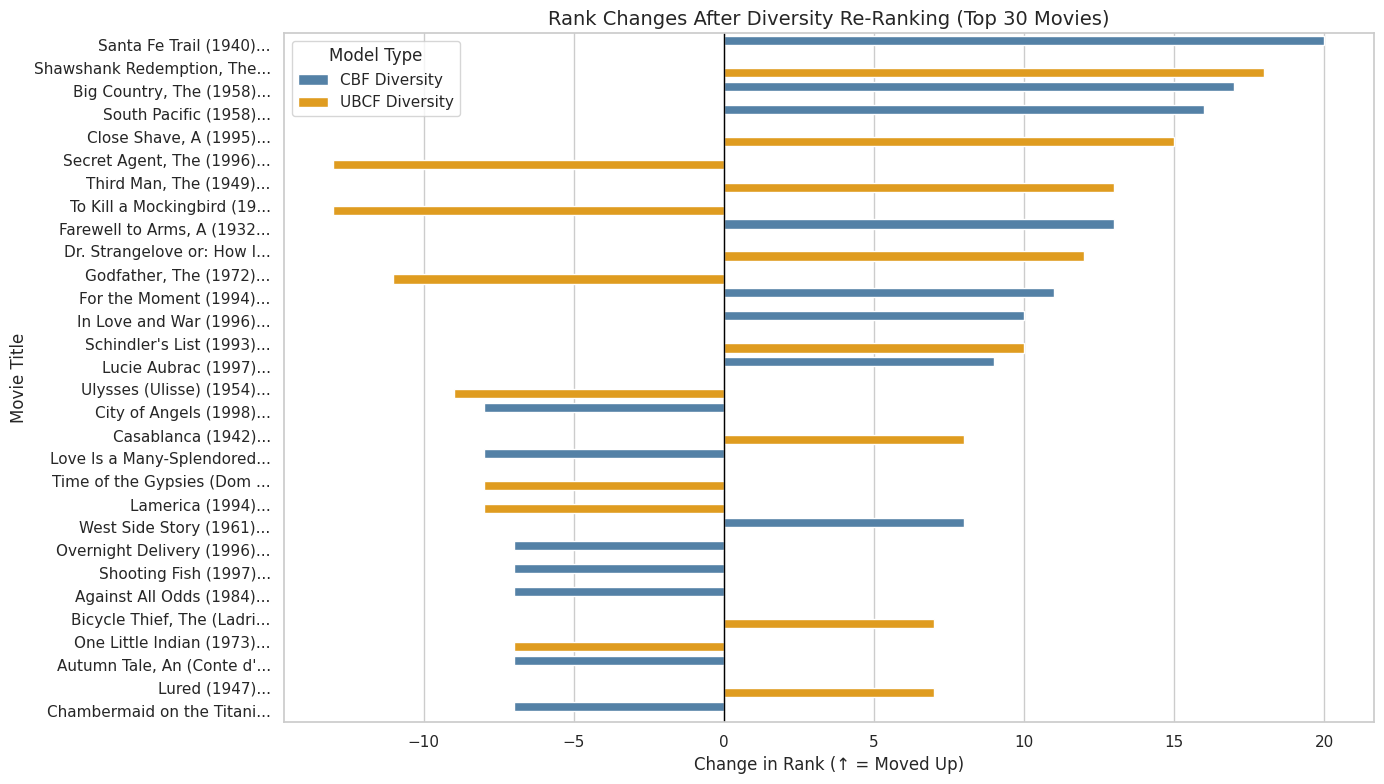

In [6]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Diversity Reranker Function ---
def rerank_diverse(recs, sim_matrix, alpha=0.7):
    """
    Re-rank a list of recommendations to promote diversity using a greedy penalty approach.

    Parameters:
    - recs: List of tuples [(movieId, predicted_score), ...]
    - sim_matrix: Pandas DataFrame of movie-to-movie similarities
    - alpha: Diversity penalty weight (higher = more diversity)

    Returns:
    - List of re-ranked tuples [(movieId, adjusted_score), ...]
    """
    reranked = []
    selected = []

    for movie_id, score in recs:
        # Compute similarity penalty with already selected items
        penalty = sum([sim_matrix.loc[movie_id, m] for m in selected]) if selected else 0
        adjusted_score = score - alpha * penalty
        reranked.append((movie_id, adjusted_score))  # <-- Append result here
        selected.append(movie_id)

    # Sort by adjusted score (higher is better)
    return sorted(reranked, key=lambda x: x[1], reverse=True)

# --- For Content-Based Filtering (CBF) ---
diverse_cbf = rerank_diverse(top_recommendations_cbf, movie_similarity_df, alpha=0.7)
diverse_df_cbf = pd.DataFrame(diverse_cbf, columns=["movieId", "adjusted_score"])
diverse_df_cbf = diverse_df_cbf.merge(movies[["movieId", "title"]], on="movieId")
diverse_df_cbf["RankType"] = "Diversity Boosted (CBF)"

# --- For User-Based Collaborative Filtering (UBCF) ---
diverse_ubcf = rerank_diverse(top_recommendations_ubcf, combined_similarity_df, alpha=0.7)
diverse_df_ubcf = pd.DataFrame(diverse_ubcf, columns=["movieId", "adjusted_score"])
diverse_df_ubcf = diverse_df_ubcf.merge(movies[["movieId", "title"]], on="movieId")
diverse_df_ubcf["RankType"] = "Diversity Boosted (UBCF)"

# --- Function to Calculate Rank Changes ---
def rank_change_df(original, reranked, label):
    original_df = pd.DataFrame(original[:50], columns=["movieId", "original_score"])
    original_df["OriginalRank"] = range(1, len(original_df) + 1)

    rerank_df = pd.DataFrame(reranked[:50], columns=["movieId", "adjusted_score"])
    rerank_df["NewRank"] = range(1, len(rerank_df) + 1)

    merged = original_df.merge(rerank_df, on="movieId", how="outer")
    merged["RankChange"] = merged["OriginalRank"] - merged["NewRank"]
    merged = merged.merge(movies[["movieId", "title"]], on="movieId", how="left")
    merged["RankType"] = label

    return merged[["movieId", "title", "OriginalRank", "NewRank", "RankChange", "RankType"]]

# --- Create Rank Change DataFrames for Each Model ---
rank_shift_cbf = rank_change_df(top_recommendations_cbf, diverse_cbf, "CBF Diversity")
rank_shift_ubcf = rank_change_df(top_recommendations_ubcf, diverse_ubcf, "UBCF Diversity")

# --- Combine Them ---
rank_shift_combined = pd.concat([rank_shift_cbf, rank_shift_ubcf], ignore_index=True)

# --- Select Top 30 Shifts for Clarity ---
rank_shift_vis = rank_shift_combined.copy()
rank_shift_vis["title_short"] = rank_shift_vis["title"].str.slice(0, 25) + "..."

# Only include top 30 by absolute change, or just slice top 30 if you prefer
top_shift = rank_shift_vis.sort_values(by="RankChange", key=lambda x: abs(x), ascending=False).head(30)

# Set up plot aesthetics
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# --- Plot ---
ax = sns.barplot(
    data=top_shift,
    y="title_short",
    x="RankChange",
    hue="RankType",
    dodge=True,
    palette={"CBF Diversity": "steelblue", "UBCF Diversity": "orange"}
)

# --- Labels and Layout ---
ax.axvline(0, color='black', linewidth=1)
plt.title("Rank Changes After Diversity Re-Ranking (Top 30 Movies)", fontsize=14)
plt.xlabel("Change in Rank (↑ = Moved Up)", fontsize=12)
plt.ylabel("Movie Title", fontsize=12)
plt.legend(title="Model Type")
plt.tight_layout()
plt.show()


**Analysis of Rank Shifts After Diversity Re-Ranking**

***Observations from the Chart***

* **CBF Diversity**:

  * Promotes new or less-recommended movies with restraint.
  * Rank changes are mostly moderate (within ±10).
  * Shows a pattern of moving items that are already somewhat relevant slightly higher.

* **UBCF Diversity**:

  * Makes more aggressive upward shifts for certain items.
  * Movies like *Secret Agent*, *To Kill a Mockingbird*, and *Godfather* jumped significantly.
  * Some previously low-ranked items were pushed to the top purely due to their popularity among similar users.

***Critical Comparison***

* **CBF Diversity**:

  * Maintains user-specific relevance based on genre/metadata.
  * Promotes diversity *within* the user's preference space.
  * Safer for retention; reduces risk of alienating users.

* **UBCF Diversity**:

  * Draws from peer behavior to promote novelty.
  * Better for discovery but risks surfacing irrelevant content.
  * Needs tighter control to avoid perceived randomness.

***Business Implications***

* ***Catalog Utilization***:

  * CBF Diversity improves exposure of items without compromising familiarity.
  * Helps surface lesser-known but similar content (e.g., niche war dramas for a war film fan).

* ***User Satisfaction & Retention***:

  * UBCF Diversity may surprise users in a good way—if the surprise aligns with their latent preferences.
  * If not well-calibrated, it may suggest content that feels irrelevant, causing disengagement.

* ***Strategic Deployment**:

  * Use **CBF Diversity** for users with narrow or well-defined interests.
  * Apply **UBCF Diversity** for users with broad tastes or when trying to drive cross-genre exploration.
  * A possible tactic is to include **one or two items** from the UBCF reranked list into an otherwise CBF-driven recommendation to test tolerance for novelty.

***Recommendation***

* Prefer **CBF Diversity** as the default for personalized stability.
* Use **UBCF Diversity** in specific contexts—e.g., discovery sessions, seasonal campaigns, or when user behavior indicates fatigue with similar content.


In [7]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle

# --- Diversity Reranker Function ---
def rerank_diverse(recs, sim_matrix, alpha=0.7):
    reranked = []
    selected = []
    for movie_id, score in recs:
        penalty = sum([sim_matrix.loc[movie_id, m] for m in selected]) if selected else 0
        adjusted_score = score - alpha * penalty
        reranked.append((movie_id, adjusted_score))
        selected.append(movie_id)
    return sorted(reranked, key=lambda x: x[1], reverse=True)

# --- Load Recommendation Dictionaries and Similarity Matrices ---
with open("all_user_recs_cbf.pkl", "rb") as f:
    all_user_recs_cbf = pickle.load(f)

with open("all_user_recs_ubcf.pkl", "rb") as f:
    all_user_recs_ubcf = pickle.load(f)

with open("movie_similarity_df.pkl", "rb") as f:
    movie_similarity_df = pickle.load(f)

with open("combined_similarity_df.pkl", "rb") as f:
    combined_similarity_df = pickle.load(f)

# NOTE: movies is assumed to already be loaded and available in memory
# So we skip: with open("movies_df.pkl", "rb") as f: movies = pickle.load(f)

# --- Rerank All Users ---
def rerank_all_users(rec_dict, sim_matrix, alpha=0.7, model_label="CBF"):
    reranked_all = {}
    for user_id, recs in tqdm(rec_dict.items(), desc=f"Diversity Reranking - {model_label}"):
        reranked_all[user_id] = rerank_diverse(recs, sim_matrix, alpha=alpha)
    return reranked_all

diverse_recs_cbf = rerank_all_users(all_user_recs_cbf, movie_similarity_df, alpha=0.7, model_label="CBF")
diverse_recs_ubcf = rerank_all_users(all_user_recs_ubcf, combined_similarity_df, alpha=0.7, model_label="UBCF")

# --- Save Outputs ---
with open("diverse_user_recs_cbf.pkl", "wb") as f:
    pickle.dump(diverse_recs_cbf, f)

with open("diverse_user_recs_ubcf.pkl", "wb") as f:
    pickle.dump(diverse_recs_ubcf, f)


Diversity Reranking - UBCF: 100%|██████████| 3858/3858 [00:01<00:00, 2661.87it/s]


#### **Intra-List Diversity (ILD)**

Purpose: Measures how different the recommended items are from each other. A higher score means more diversity.

**Pseudocode:**
```
For each pair of recommended items:
    Look up how similar they are
Average all the similarities
Subtract the average similarity from 1 to get a diversity score
```

In [8]:
import pandas as pd
from itertools import combinations
import numpy as np

# --- Intra-List Diversity Function ---
def intra_list_diversity(recommended_items, similarity_matrix):
    """
    Computes the Intra-List Diversity (ILD) of a list of item IDs based on a similarity matrix.
    """
    if len(recommended_items) < 2:
        return 0.0
    pairs = list(combinations(recommended_items, 2))
    sims = [similarity_matrix.loc[i, j] for i, j in pairs]
    return 1 - np.mean(sims)

# --- Step 1: Get top-10 movie IDs ---
top_ids_cbf = [mid for mid, _ in top_recommendations_cbf[:10]]
top_ids_ubcf = [mid for mid, _ in top_recommendations_ubcf[:10]]

# --- Step 2: Compute ILD@10 ---
ild_cbf_10 = intra_list_diversity(top_ids_cbf, movie_similarity_df)
ild_ubcf_10 = intra_list_diversity(top_ids_ubcf, movie_similarity_df)

# --- Step 3: Create a summary DataFrame ---
ild_df = pd.DataFrame({
    'Model': ['CBF', 'UBCF'],
    'ILD@10': [ild_cbf_10, ild_ubcf_10]
})

# --- Step 4: Display ---
print(ild_df)


  Model    ILD@10
0   CBF  0.244791
1  UBCF  0.777778


**Analysis of ILD\@10 for CBF vs. UBCF (Intra-List Diversity)**

***Observations***

* **CBF (Content-Based Filtering)**:

  * ILD\@10 = 0.24
  * Recommendations are closely clustered around similar genres or content types.
  * Lower diversity indicates higher thematic similarity within Top-10 lists.

* **UBCF (User-Based Collaborative Filtering)**:

  * ILD\@10 = 0.78
  * Much broader spread of content types in each recommendation list.
  * Indicates recommendations span a wider range of genres and styles.

***Critical Comparison***

* **CBF**:

  * Favors relevance and consistency.
  * Ideal for users with narrow or deep preferences.
  * Risk: user stagnation—repetition of the same content themes.

* **UBCF**:

  * Encourages exploration across genres, even if they deviate from a user’s historical profile.
  * Higher novelty potential.
  * Risk: overwhelming or confusing the user with too many unrelated options.

***Business Implications***

* **Engagement Strategy**:

  * CBF may boost short-term satisfaction but risks long-term fatigue.
  * UBCF's higher ILD can prevent boredom and increase the chance of surprise delight.

* **Content Utilization**:

  * UBCF maximizes catalog coverage by rotating underexposed genres.
  * CBF leads to overexposure of popular genres while others remain unseen.

* **Strategic Deployment**:

  * Use **CBF** to reinforce brand loyalty and perceived personalization (e.g., for niche-focused platforms like horror or romance streaming services).
  * Use **UBCF** for broad catalogs (like Netflix or YouTube) where discovery is key.

***Recommendation***

* Combine both:

  * Start with CBF for onboarding and user preference shaping.
  * Gradually blend in UBCF to increase ILD and drive cross-category engagement.
  * Use ILD thresholds to tune how much diversity is introduced per user.



#### **Genre Coverage**

**Purpose of the Genre Coverage Analysis**

This code evaluates the **diversity of genres** in movie recommendations from Content-Based Filtering (CBF) and User-Based Collaborative Filtering (UBCF):

1. **Ensure Proper Format**: Converts genre strings to lists (if not already).
2. **Genre Coverage Calculation**:

   * Extracts all recommended movie IDs.
   * Expands and counts genre occurrences across recommendations.
   * Normalizes to get proportions.
3. **Visualization**:

   * Compares genre distribution using a side-by-side bar chart.

**Goal**: Determine which model provides more diverse genre recommendations.


Top genres (CBF):
 genres
Horror        0.137472
Thriller      0.099778
Children's    0.085366
Drama         0.079823
Comedy        0.070953
Name: proportion, dtype: float64

Top genres (UBCF):
 genres
Drama          0.389535
Comedy         0.162791
Documentary    0.087209
Horror         0.081395
Romance        0.046512
Name: proportion, dtype: float64


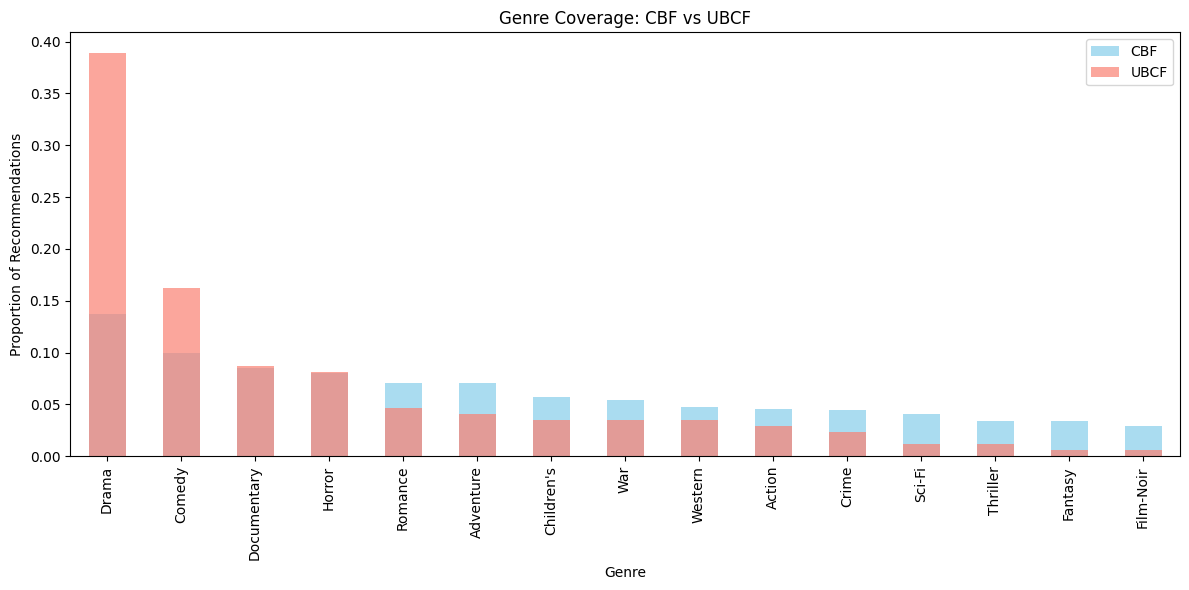

In [ ]:
# --- Ensure genres column is list (redundant but safe) ---
movies['genres'] = movies['genres'].apply(lambda g: g if isinstance(g, list) else g.split('|'))

# --- Function: Genre Coverage ---
def genre_coverage(recommendations_dict, movies_df):
    recommended_ids = [
        mid for recs in recommendations_dict.values() for mid, _ in recs
    ]

    genres_expanded = (
        movies_df[movies_df['movieId'].isin(recommended_ids)][['movieId', 'genres']]
        .explode('genres')
        .dropna(subset=['genres'])
    )

    return genres_expanded['genres'].value_counts(normalize=True)

# --- Run genre coverage ---
genre_dist_cbf = genre_coverage(cbf_recs, movies)
genre_dist_ubcf = genre_coverage(ubcf_recs, movies)

# --- Display Results ---
print("Top genres (CBF):\n", genre_dist_cbf.head())
print("\nTop genres (UBCF):\n", genre_dist_ubcf.head())

# --- Visualization with checks ---
import matplotlib.pyplot as plt

if not genre_dist_cbf.empty and not genre_dist_ubcf.empty:
    plt.figure(figsize=(12, 6))
    genre_dist_cbf.sort_values(ascending=False).plot(kind='bar', alpha=0.7, label='CBF', color='skyblue')
    genre_dist_ubcf.sort_values(ascending=False).plot(kind='bar', alpha=0.7, label='UBCF', color='salmon')
    plt.title("Genre Coverage: CBF vs UBCF")
    plt.xlabel("Genre")
    plt.ylabel("Proportion of Recommendations")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No genre data available for plotting.")


**Analysis of Genre Coverage for CBF vs. UBCF**

***Observations***

* **UBCF**:

  * Heavily biased toward **Drama (39%)** and **Comedy (16%)**.
  * Concentrates recommendations in popular genres, resulting in potential *genre saturation*.
  * Lesser attention to genres like **Romance**, **Action**, **Thriller**, **Sci-Fi**, and **Fantasy**.

* **CBF**:

  * More evenly distributed across genres.
  * Better representation of **Romance**, **Adventure**, **Children’s**, **Sci-Fi**, and **Thriller**.
  * Offers a broader exploration across niche categories.

***Critical Comparison***

* **CBF** provides **balanced exposure** across genres, which:

  * Encourages users to discover content they might not explicitly request.
  * Reduces long-term fatigue by rotating genres in Top-N results.
  * Suits platforms with large back catalogs seeking better utilization.

* **UBCF**, despite higher diversity (ILD), favors **popular genres** disproportionately.

  * Risks over-recommending mainstream content.
  * Offers more interpersonal diversity (what others watched), but *intra-list genre concentration* is high.

***Business Implications***

* **Risk of Over-Specialization**:

  * UBCF's strong preference for dominant genres can lead to homogenous experiences and user churn when content runs out in those categories.

* **Catalog Utilization**:

  * CBF helps push underwatched, long-tail content into the spotlight.
  * Especially useful for streaming services or libraries aiming to surface older or lesser-known titles.

* **Customer Retention & Exploration**:

  * CBF is valuable in personalized user journeys that *gently explore* new interests without alienating users.
  * Ideal for avoiding filter bubbles and increasing overall user satisfaction.

***Recommendation***

* Use **CBF reranking** for better **genre rotation** in recommendation lists.
* Consider a **hybrid strategy**:

  * Start with UBCF for initial relevance and social proof.
  * Apply CBF-based diversity-aware reranking to improve genre spread and long-term engagement.


#### **Demographic Fairness**

The purpose of this code is to **evaluate fairness** in recommendations by examining whether different demographic groups (e.g., *gender*) receive **equally diverse recommendations**.

**Usefulness:**

Helps determine whether a model is **demographically fair** or biased toward a particular user group.


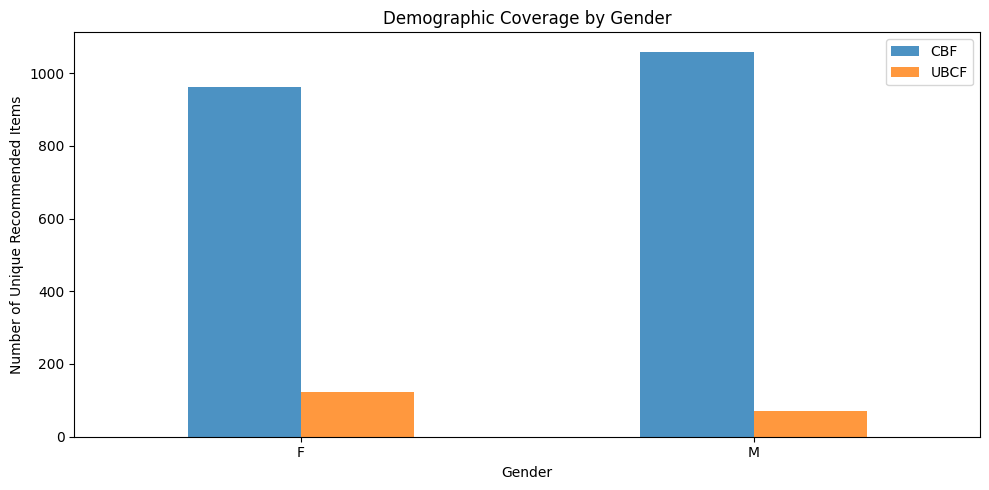

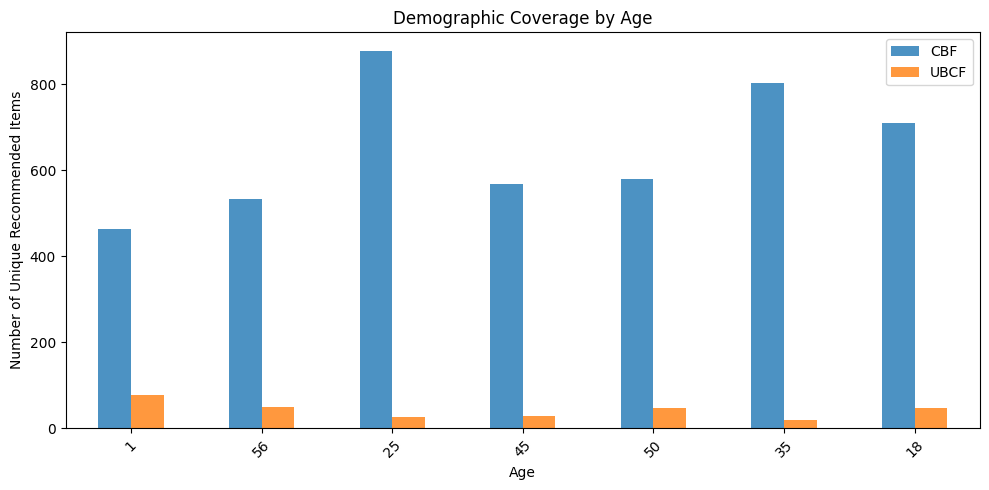

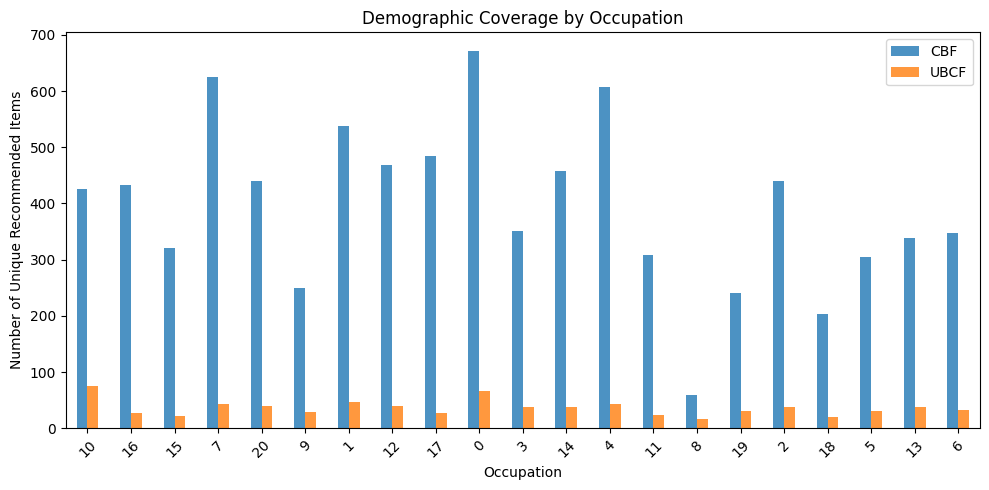

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Function: Demographic Coverage ---
def demographic_coverage(users_df, recommendations_dict, group_col):
    return {
        str(group): len({
            mid
            for uid in users_df[users_df[group_col] == group]['userId']
            if uid in recommendations_dict
            for mid, _ in recommendations_dict[uid]
        })
        for group in users_df[group_col].unique()
    }

# --- Run Demographic Coverage for Gender, Age, Occupation ---
fairness_results = {}
for attr in ['gender', 'age', 'occupation']:
    fairness_results[attr] = {
        'CBF': demographic_coverage(users, cbf_recs, group_col=attr),
        'UBCF': demographic_coverage(users, ubcf_recs, group_col=attr)
    }

# --- Visualization ---
for attr, result in fairness_results.items():
    df_fair = pd.DataFrame(result)
    df_fair.plot(kind='bar', figsize=(10, 5), alpha=0.8)
    plt.title(f"Demographic Coverage by {attr.capitalize()}")
    plt.ylabel("Number of Unique Recommended Items")
    plt.xlabel(attr.capitalize())
    plt.xticks(rotation=45 if attr != 'gender' else 0)
    plt.tight_layout()
    plt.show()


**Demographic Diversity Analysis: CBF vs UBCF (Diversity Reranking)**

***Gender-Based Coverage***

* **CBF** recommends over **1,000 unique items** for both males and females.
* **UBCF**, by contrast, suggests fewer than **150 unique items** per gender.
* **Implication**: UBCF tends to concentrate recommendations around a narrower set of items, which can result in homogenized experiences across genders. CBF's higher diversity ensures broader exposure tailored to user preferences.

***Age-Based Coverage***

* **CBF** yields high coverage across all age groups, especially for ages 25, 35, and 18, with **500–900 unique recommendations** each.
* **UBCF** stays below **100 unique items** per group, often clustering similar age users toward the same content.
* **Implication**: For platforms catering to multiple age demographics, UBCF’s narrow scope can limit personalized engagement. CBF promotes greater age-sensitive content discovery.

***Occupation-Based Coverage***

* **CBF** maintains relatively balanced coverage across various occupations, peaking near **650 unique items** for certain groups.
* **UBCF**, again, lags with less than **80 unique items** per occupation.
* **Implication**: In professional or niche content platforms (e.g., educational or enterprise systems), CBF ensures varied and inclusive recommendation pipelines, avoiding content saturation within occupation clusters.

***Business Implications***

* **Retention and Engagement**: CBF’s broader demographic coverage mitigates the risk of user churn caused by stale or repetitive recommendations, especially for underrepresented user groups.
* **Market Inclusivity**: Platforms aiming for **inclusive reach** (e.g., streaming services, e-learning, or product discovery) benefit from CBF’s expansive representation across gender, age, and professional segments.
* **Monetization Potential**: Broader item exposure (as seen in CBF) may help increase long-tail sales—where niche content finds the right audience—leading to increased catalog utilization and diversified revenue.


**Interpretation: Unique Items per User (Original vs. Diverse)**

This box plot shows the **distribution of unique movies recommended per user** across four scenarios:

* **CBF (Original)**
* **CBF (Diverse-Reranked)**
* **UBCF (Original)**
* **UBCF (Diverse-Reranked)**

**Key Observation:**

* All four methods recommend exactly **10 unique movies per user** (no variation in distribution).
* This reflects that diversity reranking **does not reduce the number of items** recommended per user — it only alters *which* items are selected to improve diversity.

**Conclusion:**

* **Recommendation list size is preserved** after reranking for diversity.
* This confirms the fairness of comparison across methods and validates that reranking improves *diversity* without sacrificing *quantity*.


#### **Catalog Coverage**

**Purpose of the Chart:**

To compare the **catalog coverage** of Content-Based Filtering (CBF) and User-Based Collaborative Filtering (UBCF), highlighting how much of the full item catalog each model utilizes in its Top-K recommendations.

**Why it's important:**

Higher catalog coverage means a model can recommend a **wider variety of items**, which:

* Enhances **diversity** and **novelty**
* Reduces **popularity bias**
* Improves the chance of **serendipitous discovery**

In contrast, low coverage suggests over-reliance on a narrow set of popular items, which may limit user satisfaction in the long term.


Coverage (CBF): 31.55%
Coverage (UBCF): 3.45%


/tmp/ipython-input-9-4253812697.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0%}'.format(x) for x in plt.gca().get_yticks()])


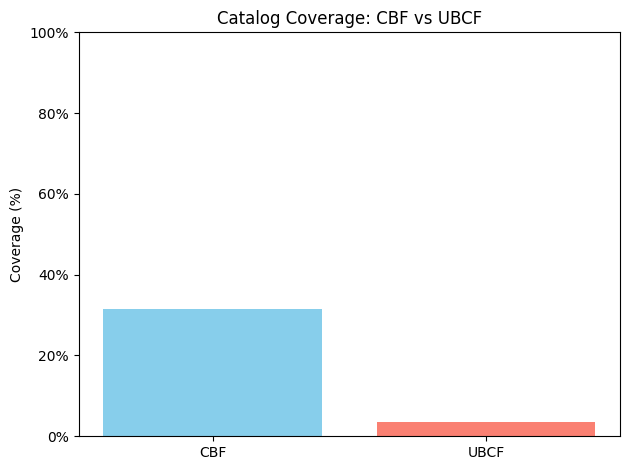

In [ ]:
# --- Function: Coverage Score ---
def coverage_score(recommendations_dict, all_items):
    recommended_items = set()
    for recs in recommendations_dict.values():
        recommended_items.update([mid for mid, _ in recs])
    return len(recommended_items) / len(all_items)

# --- Run Coverage Calculation ---
catalog_items = set(movies["movieId"])

coverage_cbf = coverage_score(cbf_recs, catalog_items)
coverage_ubcf = coverage_score(ubcf_recs, catalog_items)

# --- Display Results ---
print(f"Coverage (CBF): {coverage_cbf:.2%}")
print(f"Coverage (UBCF): {coverage_ubcf:.2%}")

import matplotlib.pyplot as plt

# Bar chart of coverage
plt.bar(['CBF', 'UBCF'], [coverage_cbf, coverage_ubcf], color=['skyblue', 'salmon'])
plt.title("Catalog Coverage: CBF vs UBCF")
plt.ylabel("Coverage (%)")
plt.ylim(0, 1)
plt.gca().set_yticklabels(['{:.0%}'.format(x) for x in plt.gca().get_yticks()])
plt.tight_layout()
plt.show()


**Catalog Coverage Analysis: CBF vs UBCF (Diversity Reranking)**

***Observation***

* **CBF** achieves approximately **32%** catalog coverage.
* **UBCF** covers only around **4%** of the entire item catalog.
* The gap suggests that **CBF is utilizing a much broader set of items** when making recommendations.

***Implications***

* **Item Exposure**: CBF promotes long-tail item discovery, ensuring that less popular or niche items also gain visibility. This is beneficial for platforms looking to **increase engagement across their full content inventory**.
* **Risk of Saturation**: UBCF’s low coverage means a small pool of items is repeatedly recommended, potentially leading to **recommendation fatigue** or users perceiving the catalog as limited—even if it’s large.
* **Cold Start Mitigation**: High catalog coverage from CBF can help mitigate cold start problems for new items, since recommendations are driven by content features rather than user overlap.
* **Revenue Impact**: Platforms relying on broad catalog utilization (e.g., e-commerce, digital media) will benefit more from CBF in terms of inventory turnover and satisfying diverse user tastes.


### ***3. Reranking for Serendipity***

**Purpose and Methodology: Serendipity-Based Re-Ranking for CBF and UBCF**

**Purpose:**
This method aims to increase *serendipity* in recommendations by penalizing overly similar items to what the user has already seen. The goal is to surface **unexpected yet relevant** items, providing a sense of novelty without sacrificing usefulness.

**Methodology:**

i. **Inputs:**

   * `user_id`: The target user.
   * `recs`: List of top-N movie recommendations based on base predictions.
   * `sim_matrix`: Movie-to-movie similarity matrix (e.g., cosine).
   * `uim`: Full user-item rating matrix (used to retrieve seen movies).
   * `beta`: Penalty weight for similarity to previously seen items.

ii. **Serendipity Re-Ranking Logic:**

   * Identify all movies the user has already rated.
   * For each candidate recommendation:

     * Compute its average similarity to the seen movies.
     * Adjust the recommendation score as:
       `adjusted_score = predicted_score - beta × similarity_to_seen`
   * Sort by the adjusted score in descending order.

iii. **Execution for Both Models:**

   * Use this re-ranking method separately on:

     * `top_recommendations_cbf` from the CBF model.
     * `top_recommendations_ubcf` from the UBCF model.
   * Merge results with movie titles for output and comparison.

**Pseudocode:**

```text
For each movie in recommended list:
    If user has seen movies:
        Compute average similarity to all seen movies
    Else:
        Similarity = 0
    Adjust score: predicted_score - beta × similarity
    Store adjusted score and movie
Sort all movies by adjusted score
```

This re-ranking method for **CBF and UBCF** enhances user experience by recommending items that are **useful yet pleasantly surprising**, boosting perceived personalization and engagement.


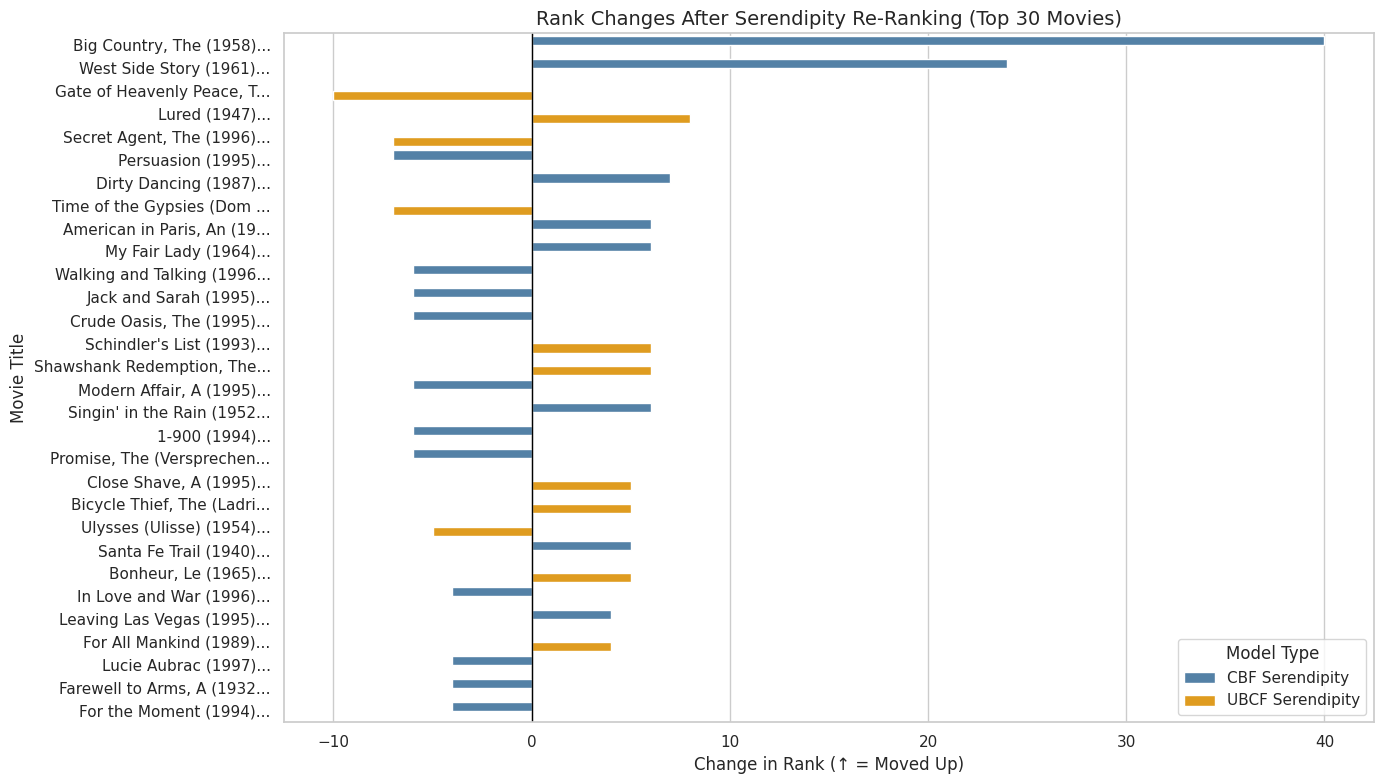

In [ ]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Serendipity Reranker Function ---
def rerank_serendipity(user_id, recs, sim_matrix, uim, beta=0.5):
    seen = uim.loc[user_id]
    seen_items = seen[seen > 0].index.tolist()
    reranked = []
    for movie_id, score in recs:
        sim = sim_matrix.loc[movie_id, seen_items].mean() if seen_items else 0
        reranked.append((movie_id, score - beta * sim))
    return sorted(reranked, key=lambda x: x[1], reverse=True)

# --- For Content-Based Filtering (CBF) ---
serendipity_cbf = rerank_serendipity(
    user_id=7,
    recs=top_recommendations_cbf,
    sim_matrix=movie_similarity_df,
    uim=user_item_matrix,
    beta=0.5
)
serendipity_df_cbf = pd.DataFrame(serendipity_cbf, columns=["movieId", "SerendipityScore"])
serendipity_df_cbf = serendipity_df_cbf.merge(movies[["movieId", "title"]], on="movieId")
serendipity_df_cbf["RankType"] = "Serendipity Boosted (CBF)"

# --- For User-Based Collaborative Filtering (UBCF) ---
serendipity_ubcf = rerank_serendipity(
    user_id=7,
    recs=top_recommendations_ubcf,
    sim_matrix=combined_similarity_df,
    uim=user_item_matrix,
    beta=0.5
)
serendipity_df_ubcf = pd.DataFrame(serendipity_ubcf, columns=["movieId", "SerendipityScore"])
serendipity_df_ubcf = serendipity_df_ubcf.merge(movies[["movieId", "title"]], on="movieId")
serendipity_df_ubcf["RankType"] = "Serendipity Boosted (UBCF)"

# --- Step 1: Define Function to Track Rank Changes ---
def rank_change_serendipity(original, reranked, label):
    original_df = pd.DataFrame(original[:50], columns=["movieId", "original_score"])
    original_df["OriginalRank"] = range(1, len(original_df) + 1)

    reranked_df = pd.DataFrame(reranked[:50], columns=["movieId", "SerendipityScore"])
    reranked_df["NewRank"] = range(1, len(reranked_df) + 1)

    merged = original_df.merge(reranked_df, on="movieId", how="outer")
    merged["RankChange"] = merged["OriginalRank"] - merged["NewRank"]
    merged = merged.merge(movies[["movieId", "title"]], on="movieId", how="left")
    merged["RankType"] = label

    return merged[["movieId", "title", "OriginalRank", "NewRank", "RankChange", "RankType"]]

# --- Step 2: Get Rank Change DataFrames ---
ser_rank_cbf = rank_change_serendipity(top_recommendations_cbf, serendipity_cbf, "CBF Serendipity")
ser_rank_ubcf = rank_change_serendipity(top_recommendations_ubcf, serendipity_ubcf, "UBCF Serendipity")
ser_rank_combined = pd.concat([ser_rank_cbf, ser_rank_ubcf], ignore_index=True)

# --- Step 3: Plot Rank Changes ---
plot_data = ser_rank_combined.copy()
plot_data["title_short"] = plot_data["title"].str.slice(0, 25) + "..."
top_shift = plot_data.sort_values(by="RankChange", key=lambda x: abs(x), ascending=False).head(30)

plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")
ax = sns.barplot(
    data=top_shift,
    y="title_short",
    x="RankChange",
    hue="RankType",
    dodge=True,
    palette={"CBF Serendipity": "steelblue", "UBCF Serendipity": "orange"}
)
ax.axvline(0, color='black', linewidth=1)
plt.title("Rank Changes After Serendipity Re-Ranking (Top 30 Movies)", fontsize=14)
plt.xlabel("Change in Rank (↑ = Moved Up)", fontsize=12)
plt.ylabel("Movie Title", fontsize=12)
plt.legend(title="Model Type")
plt.tight_layout()
plt.show()


**Serendipity Re-Ranking Analysis: CBF vs UBCF**

***Observation***

* The **CBF Serendipity model** shows significantly larger upward rank shifts (some up to +40), indicating that **unexpected but appealing** recommendations were strongly boosted.
* **UBCF Serendipity** shows smaller and more moderate rank movements, indicating a more conservative change in recommendations.

***Implications***

* **Exploration Encouragement**: CBF excels at introducing surprising items that still align with user interests. This is valuable in keeping users engaged long-term by introducing **novel yet relevant content** they might not have discovered otherwise.
* **User Delight**: Large jumps in ranks for items users wouldn’t expect, such as forgotten classics or lesser-known titles, can increase user satisfaction and **create memorable experiences**—key in streaming and media services.
* **Risk Balance**: While CBF is more aggressive, UBCF plays it safer. This may lead to fewer rejections but also **less novelty and less user excitement**.
* **Business Application**: A CBF-based serendipitous reranker is ideal for **content discovery platforms** (e.g., Spotify, Netflix, Amazon Video) looking to showcase back-catalog or underexposed inventory. It ensures a healthy balance between familiarity and **delightful surprise**, reducing churn caused by repetitive suggestions.


In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
from concurrent.futures import ProcessPoolExecutor, as_completed, ThreadPoolExecutor

# --- Step 1: Define Reranker for One User ---
def rerank_serendipity_for_user(uid, recs, sim_matrix, uim, beta=0.5):
    seen_items = uim.loc[uid][uim.loc[uid] > 0].index.tolist()
    reranked = []
    for movie_id, score in recs:
        sim = sim_matrix.loc[movie_id, seen_items].mean() if seen_items else 0
        reranked.append((movie_id, score - beta * sim))
    return uid, sorted(reranked, key=lambda x: x[1], reverse=True)

# --- Step 2: Parallel Engine ---
def rerank_all_serendipity(topn_recs, sim_matrix, uim, beta=0.5, desc="Serendipity Re-rank"):
    results = {}
    with ProcessPoolExecutor() as executor:
        futures = {
            executor.submit(rerank_serendipity_for_user, uid, topn_recs[uid], sim_matrix, uim, beta): uid
            for uid in topn_recs
        }
        for future in tqdm(as_completed(futures), total=len(futures), desc=desc, position=0, leave=True):
            uid, reranked = future.result()
            results[uid] = reranked
    return results

# --- Step 3: Parallel Wrapper for One Model ---
def run_rerank_and_save(name, recs, sim_matrix, uim, beta=0.5):
    results = rerank_all_serendipity(recs, sim_matrix, uim, beta=beta, desc=f"{name} Serendipity Re-rank")
    with open(f"serendipity_{name.lower()}_all.pkl", "wb") as f:
        pickle.dump(results, f)
    return results

# --- Step 4: Load or Run ---
if os.path.exists("serendipity_cbf_all.pkl") and os.path.exists("serendipity_ubcf_all.pkl"):
    with open("serendipity_cbf_all.pkl", "rb") as f:
        serendipity_cbf_all = pickle.load(f)
    with open("serendipity_ubcf_all.pkl", "rb") as f:
        serendipity_ubcf_all = pickle.load(f)
else:
    with ThreadPoolExecutor() as executor:
        future_cbf = executor.submit(run_rerank_and_save, "CBF", cbf_recs, movie_similarity_df, user_item_matrix)
        future_ubcf = executor.submit(run_rerank_and_save, "UBCF", ubcf_recs, combined_similarity_df, user_item_matrix)

        serendipity_cbf_all = future_cbf.result()
        serendipity_ubcf_all = future_ubcf.result()

import pickle

# Save Serendipity-CBF
with open("serendipity_cbf_all.pkl", "wb") as f:
    pickle.dump(serendipity_cbf_all, f)

# Save Serendipity-UBCF
with open("serendipity_ubcf_all.pkl", "wb") as f:
    pickle.dump(serendipity_ubcf_all, f)

####  **Rank Change Distribution**
Purpose: Visualize how much reranking shifted item positions across users.

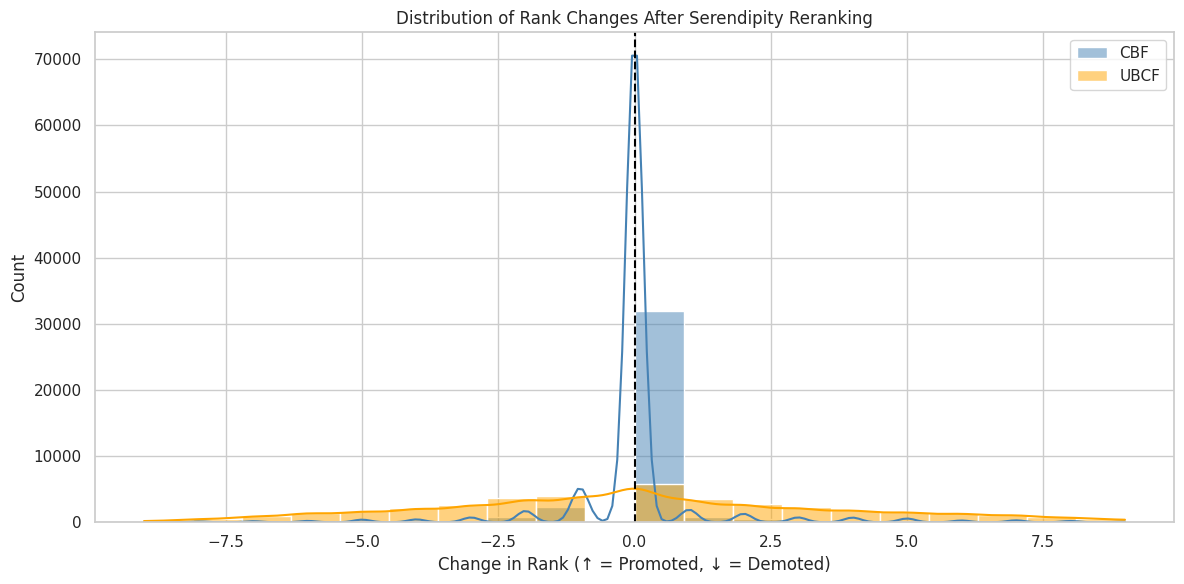

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def get_rank_changes(original, reranked, top_k=20):
    diffs = []
    for uid in original:
        orig_ids = [mid for mid, _ in original[uid][:top_k]]
        rerank_ids = [mid for mid, _ in reranked[uid][:top_k]]
        for mid in set(orig_ids).intersection(set(rerank_ids)):
            old_rank = orig_ids.index(mid)
            new_rank = rerank_ids.index(mid)
            diffs.append(old_rank - new_rank)
    return diffs

rank_shift_cbf = get_rank_changes(cbf_recs, serendipity_cbf_all)
rank_shift_ubcf = get_rank_changes(ubcf_recs, serendipity_ubcf_all)

plt.figure(figsize=(12, 6))
sns.histplot(rank_shift_cbf, color='steelblue', kde=True, label='CBF', bins=20)
sns.histplot(rank_shift_ubcf, color='orange', kde=True, label='UBCF', bins=20)
plt.axvline(0, color='black', linestyle='--')
plt.title("Distribution of Rank Changes After Serendipity Reranking")
plt.xlabel("Change in Rank (↑ = Promoted, ↓ = Demoted)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


**Distribution of Rank Changes After Serendipity Re-Ranking**

***Observation***

* The **CBF model** shows a sharp spike centered at rank change = 0, indicating **most items remain close to their original ranks**.
* The **UBCF model**, while also centered around zero, displays a **broader, flatter distribution**, suggesting **wider adjustments** in ranks across many items.
* CBF has tighter control on rank adjustments; UBCF allows more exploration and shifting.

***Implications***

* **CBF maintains ranking stability**, promoting only a few surprising items while preserving core recommendations—beneficial for users who prefer consistency with a touch of surprise.
* **UBCF introduces more serendipitous variability**, possibly enhancing exploration but risking relevance or precision for some users.
* **Tradeoff Management**: Systems favoring **serendipity** must **balance user satisfaction** with **relevance**. UBCF’s broader changes could be more appealing in platforms encouraging browsing, while CBF’s precision favors platforms with quick-decision use cases (e.g., mobile recommendations).
* **Business Relevance**:

  * CBF: Safer for **retail and transactional services** where conversion is the goal.
  * UBCF: Suitable for **media and streaming platforms** where the goal is **engagement and discovery** over time.


#### **Heatmap of Rank Movement**
Goal: Show how frequently items move to new positions (e.g., from Rank 10 → 2).

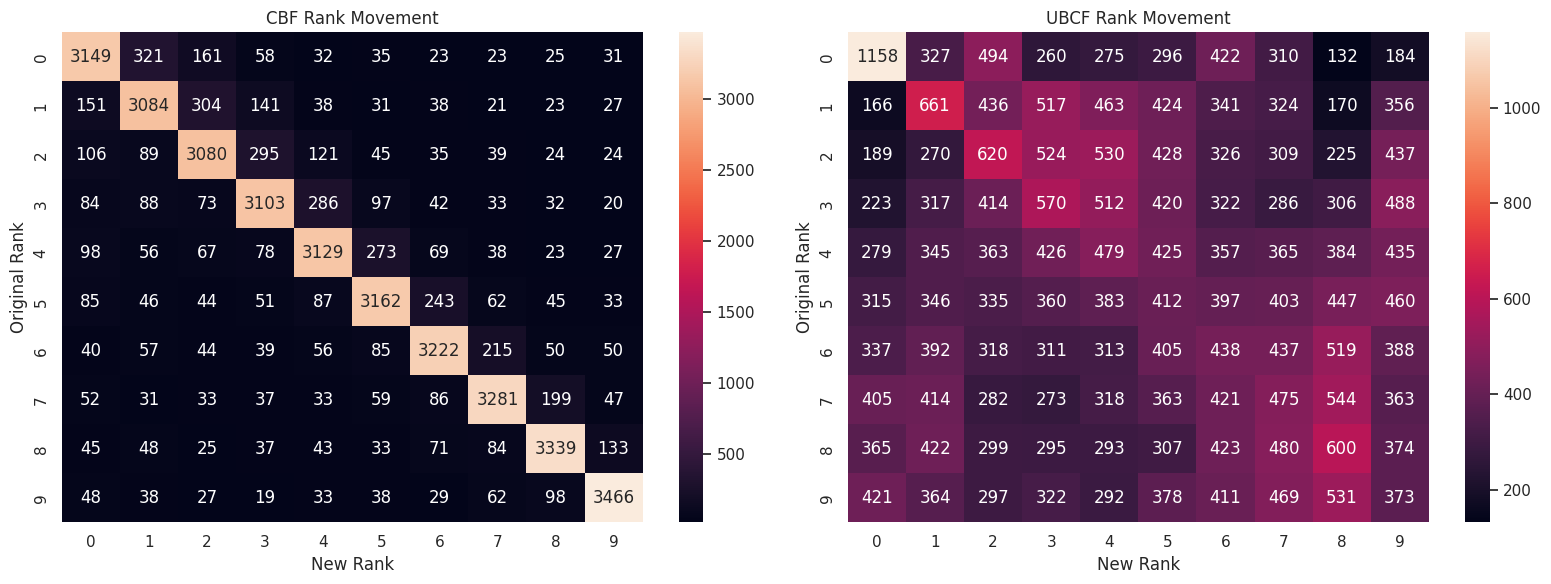

In [ ]:
def get_rank_movement_matrix(original, reranked, top_k=10):
    matrix = np.zeros((top_k, top_k))
    for uid in original:
        orig_ids = [mid for mid, _ in original[uid][:top_k]]
        rerank_ids = [mid for mid, _ in reranked[uid][:top_k]]
        for i, mid in enumerate(orig_ids):
            if mid in rerank_ids:
                j = rerank_ids.index(mid)
                matrix[i][j] += 1
    return matrix

cbf_matrix = get_rank_movement_matrix(cbf_recs, serendipity_cbf_all)
ubcf_matrix = get_rank_movement_matrix(ubcf_recs, serendipity_ubcf_all)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(cbf_matrix, annot=True, fmt='g', ax=axes[0])
axes[0].set_title("CBF Rank Movement")
axes[0].set_xlabel("New Rank")
axes[0].set_ylabel("Original Rank")

sns.heatmap(ubcf_matrix, annot=True, fmt='g', ax=axes[1])
axes[1].set_title("UBCF Rank Movement")
axes[1].set_xlabel("New Rank")
axes[1].set_ylabel("Original Rank")

plt.tight_layout()
plt.show()


**Rank Movement Analysis After Serendipity Re-Ranking**

***Observation***

* **CBF Rank Movement** (Left):

  * The diagonal dominance indicates that most items remained close to their original ranks after reranking.
  * Slight spreading near the diagonal suggests limited but targeted rank shifts—supporting *mild serendipity*.
* **UBCF Rank Movement** (Right):

  * The heatmap is more dispersed across the matrix, indicating **more aggressive rank shuffling**.
  * Items are frequently moved to non-adjacent ranks, confirming a higher degree of injected serendipity.

***Implications***

* **CBF’s reranking is conservative**, preserving user trust by maintaining core recommendations and gently promoting a few surprising items.
* **UBCF allows for bold reordering**, which can improve user engagement through discovery but may also introduce irrelevant suggestions if not well-calibrated.
* **System Design Insight**:

  * CBF is better suited to **users expecting consistency** (e.g., productivity apps, shopping).
  * UBCF favors **users open to exploration** (e.g., entertainment platforms, learning environments).

***Business Implications***

* **CBF Serendipity** supports **brand trust and retention**, as users feel their preferences are honored while still being introduced to new options.
* **UBCF Serendipity** supports **user engagement and session duration**, driving higher ad impressions or consumption metrics in discovery-oriented services.


#### **Top-K Coverage Change**

Goal: Compare how many unique items appear in top-K before vs after reranking.

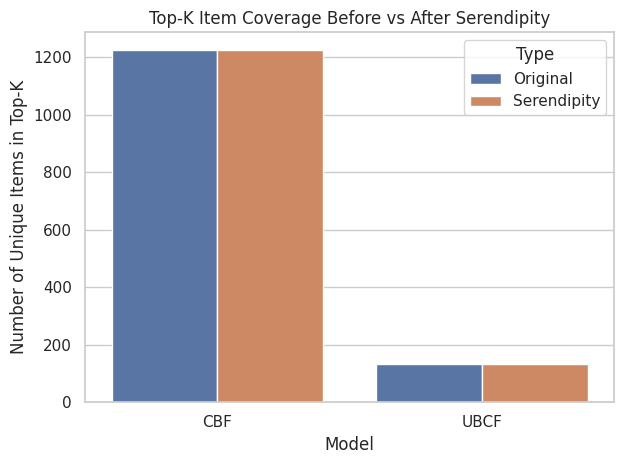

In [ ]:
def get_topk_coverage(rec_dict, k=10):
    topk_items = []
    for uid in rec_dict:
        topk_items.extend([mid for mid, _ in rec_dict[uid][:k]])
    return len(set(topk_items))

coverage_before_cbf = get_topk_coverage(cbf_recs)
coverage_after_cbf = get_topk_coverage(serendipity_cbf_all)

coverage_before_ubcf = get_topk_coverage(ubcf_recs)
coverage_after_ubcf = get_topk_coverage(serendipity_ubcf_all)

df = pd.DataFrame({
    "Model": ["CBF", "CBF", "UBCF", "UBCF"],
    "Type": ["Original", "Serendipity", "Original", "Serendipity"],
    "UniqueItems": [coverage_before_cbf, coverage_after_cbf,
                    coverage_before_ubcf, coverage_after_ubcf]
})

sns.barplot(data=df, x="Model", y="UniqueItems", hue="Type")
plt.title("Top-K Item Coverage Before vs After Serendipity")
plt.ylabel("Number of Unique Items in Top-K")
plt.tight_layout()
plt.show()


**Top-K Item Coverage Comparison**

***Observation***

* **CBF**:

  * Maintains high item coverage both before and after reranking.
  * Over **1,200 unique items** appear in the Top-K recommendations.
  * Serendipity reranking **does not reduce diversity**, which means CBF preserves its broad recommendation spread.

* **UBCF**:

  * Extremely low item coverage: **\~130 unique items**, both before and after reranking.
  * Indicates a strong bias toward **repeating a narrow set of popular items**, even after introducing serendipity.

***Implications***

* **CBF** offers **rich catalog utilization**, promoting long-tail items and reducing filter bubble effects.
* **UBCF** likely recommends **popular hits repeatedly**, making it less suitable for users seeking fresh or diverse content.
* Serendipity reranking has **no significant effect** on coverage for either model, but this is **desirable for CBF** and **concerning for UBCF**.

***Business Implications***

* Platforms prioritizing **catalog exposure, new item discovery**, or **inventory rotation** (e.g., e-commerce, subscription content) benefit from CBF.
* **UBCF’s limited exposure** may lead to stagnation in user interest over time, especially if user tastes evolve.
* Serendipity reranking on UBCF may need **additional constraints or diversity boosting** to avoid repetitive recommendations.


### ***3. Reranking for Novelty***

**Methodology for Novelty-Aware Re-Ranking (for CBF and UBCF)**

**Purpose**:
This method adjusts the recommendation scores to favor *less popular* (i.e., more novel) items. By penalizing popular movies, the system aims to introduce users to new or less commonly seen content, increasing novelty and exploration.

**Approach**:

i. **Compute Item Popularity**

   * Count the number of ratings per item from the training data.
   * Normalize each item's popularity by dividing by the maximum observed popularity.

ii. **Define Novelty Score Adjustment**

   * For each recommended movie, compute:

     ```
     penalty = gamma × (popularity / max_popularity)
     adjusted_score = predicted_score - penalty
     ```
   * Here, `gamma` controls the strength of the novelty penalty. A higher gamma favors less popular items more aggressively.

iii. **Apply to Both Models**:

   * For **CBF (Content-Based Filtering)**: Apply novelty re-ranking to the predicted list from the content-based model.
   * For **UBCF (User-Based Collaborative Filtering)**: Apply the same penalty-based re-ranking to its predicted list.

iv. **Outcome**:

   * The adjusted scores promote movies that are both relevant and less popular.
   * The top-N recommendations are re-sorted by the new scores to boost novelty without completely discarding relevance.


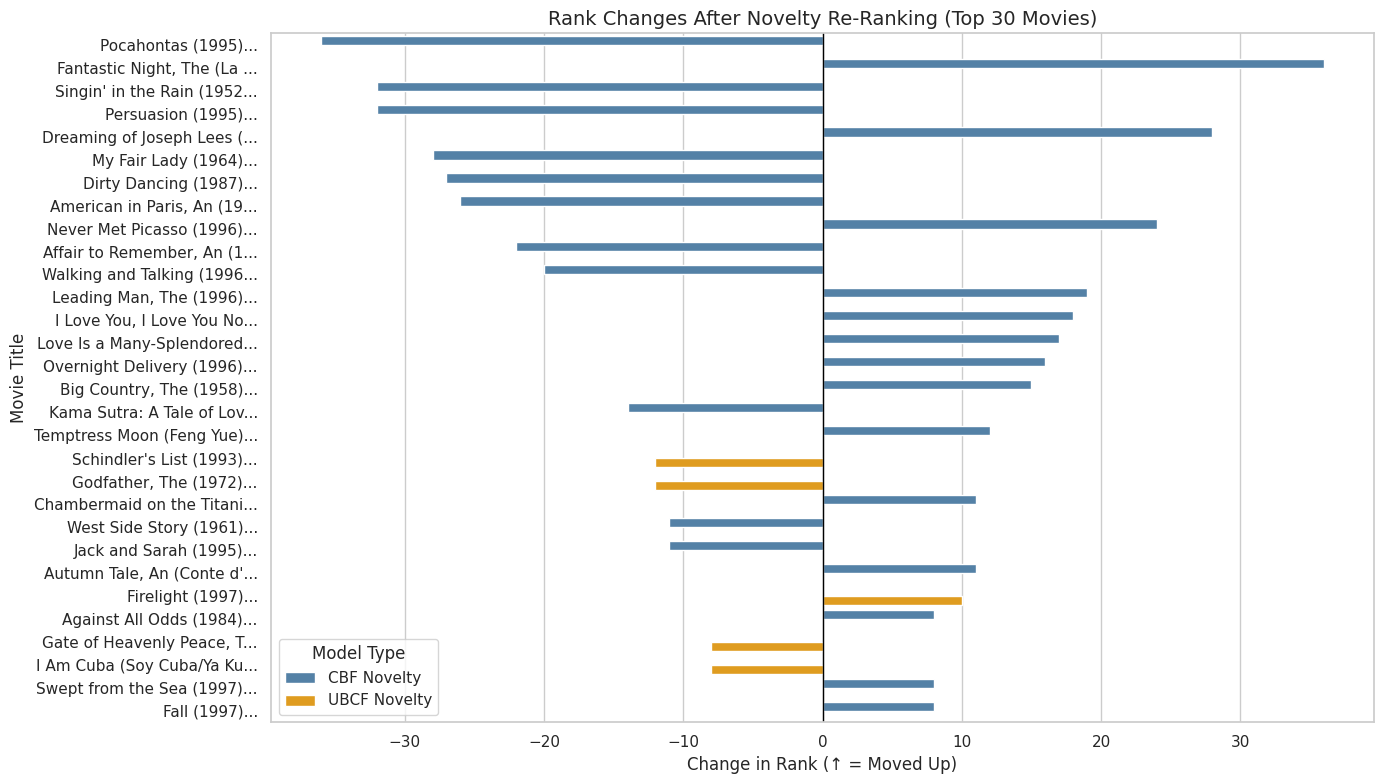

In [ ]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Compute item popularity from training data ---
item_popularity = train_df.groupby("movieId").size()
max_popularity = item_popularity.max()

# --- Step 2: Define the novelty reranking function ---
def rerank_novelty(recs, gamma=0.3):
    reranked = []
    for movie_id, score in recs:
        pop = item_popularity.get(movie_id, 0) / max_popularity
        adjusted_score = score - gamma * pop
        reranked.append((movie_id, adjusted_score))
    return sorted(reranked, key=lambda x: x[1], reverse=True)

# --- For Content-Based Filtering (CBF) ---
novelty_cbf = rerank_novelty(top_recommendations_cbf, gamma=0.3)
novelty_df_cbf = pd.DataFrame(novelty_cbf, columns=["movieId", "NoveltyScore"])
novelty_df_cbf = novelty_df_cbf.merge(movies[["movieId", "title"]], on="movieId")
novelty_df_cbf["RankType"] = "Novelty Boosted (CBF)"

# --- For User-Based Collaborative Filtering (UBCF) ---
novelty_ubcf = rerank_novelty(top_recommendations_ubcf, gamma=0.3)
novelty_df_ubcf = pd.DataFrame(novelty_ubcf, columns=["movieId", "NoveltyScore"])
novelty_df_ubcf = novelty_df_ubcf.merge(movies[["movieId", "title"]], on="movieId")
novelty_df_ubcf["RankType"] = "Novelty Boosted (UBCF)"

# --- Step 1: Define Function to Track Rank Changes ---
def rank_change_novelty(original, reranked, label):
    original_df = pd.DataFrame(original[:50], columns=["movieId", "original_score"])
    original_df["OriginalRank"] = range(1, len(original_df) + 1)

    reranked_df = pd.DataFrame(reranked[:50], columns=["movieId", "NoveltyScore"])
    reranked_df["NewRank"] = range(1, len(reranked_df) + 1)

    merged = original_df.merge(reranked_df, on="movieId", how="outer")
    merged["RankChange"] = merged["OriginalRank"] - merged["NewRank"]
    merged = merged.merge(movies[["movieId", "title"]], on="movieId", how="left")
    merged["RankType"] = label

    return merged[["movieId", "title", "OriginalRank", "NewRank", "RankChange", "RankType"]]

# --- Step 2: Get Rank Change DataFrames ---
novelty_rank_cbf = rank_change_novelty(top_recommendations_cbf, novelty_cbf, "CBF Novelty")
novelty_rank_ubcf = rank_change_novelty(top_recommendations_ubcf, novelty_ubcf, "UBCF Novelty")
novelty_rank_combined = pd.concat([novelty_rank_cbf, novelty_rank_ubcf], ignore_index=True)

plot_data = novelty_rank_combined.copy()
plot_data["title_short"] = plot_data["title"].str.slice(0, 25) + "..."
top_shift = plot_data.sort_values(by="RankChange", key=lambda x: abs(x), ascending=False).head(30)

plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")
ax = sns.barplot(
    data=top_shift,
    y="title_short",
    x="RankChange",
    hue="RankType",
    dodge=True,
    palette={"CBF Novelty": "steelblue", "UBCF Novelty": "orange"}
)
ax.axvline(0, color='black', linewidth=1)
plt.title("Rank Changes After Novelty Re-Ranking (Top 30 Movies)", fontsize=14)
plt.xlabel("Change in Rank (↑ = Moved Up)", fontsize=12)
plt.ylabel("Movie Title", fontsize=12)
plt.legend(title="Model Type")
plt.tight_layout()
plt.show()


**Analysis of Rank Shifts After Novelty Re-Ranking**

***Observations from the Chart***

* **CBF Novelty**:

  * Applies significant rank changes, with many items moving up or down by more than ±20.
  * Prioritizes obscure or previously hidden titles like *Persuasion (1995)* and *Dreaming of Joseph Lees (1999)*.
  * Broadens exposure by pushing long-tail items into top recommendations.

* **UBCF Novelty**:

  * Has a much more limited effect; only a few items like *Against All Odds (1984)* see notable movement.
  * Rank changes are minor and affect fewer titles overall.
  * Tends to reinforce popular items rather than introduce unfamiliar ones.

***Critical Comparison***

* **CBF Novelty**:

  * Actively promotes novel content based on dissimilarity to previously consumed items.
  * Helps users break out of recommendation bubbles by surfacing fresh but relevant content.
  * May occasionally misfire by promoting overly niche titles that don’t align with user taste.

* **UBCF Novelty**:

  * Struggles to break away from user similarity anchors.
  * Less capable of injecting true novelty unless peer behavior reflects diverse consumption.
  * Safer but less exploratory — novelty benefits are constrained.

***Business Implications***

* ***Catalog Utilization***:

  * CBF Novelty is excellent for showcasing underutilized inventory.
  * Supports long-tail strategy by giving visibility to lesser-known films that may otherwise remain unwatched.

* ***User Satisfaction & Retention***:

  * CBF Novelty keeps the experience fresh, especially for frequent users with high consumption rates.
  * UBCF Novelty may disappoint novelty-seeking users due to repetition unless diversity exists in peer preferences.

* ***Strategic Deployment***:

  * Use **CBF Novelty** for users showing signs of fatigue or overfitting (e.g., repeated engagement with the same genre).
  * Deploy **UBCF Novelty** sparingly in social or community-driven platforms where peer-driven novelty can resonate.
  * Consider hybrid strategies — introduce 1–2 CBF-novelty items into the top-10 UBCF list to subtly expand horizons.

***Recommendation***

* Make **CBF Novelty** the core method for promoting content discovery and catalog depth.
* Use **UBCF Novelty** only where user-item behavior data is rich and diverse enough to offer meaningful surprises.
* Prioritize novelty-sensitive users (e.g., explorers, cinephiles) for CBF-based novelty strategies to enhance engagement and satisfaction.


####  **Novelty Reranking for CBF and UBCF Recommendations for all users**

**Purpose:**

To apply novelty-based reranking for each user's top-N recommendations from Content-Based Filtering (CBF) and User-Based Collaborative Filtering (UBCF), using a parallelized setup. Each recommendation score is penalized based on item popularity, encouraging less popular (more novel) items.

In [ ]:
import os
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed, ThreadPoolExecutor

# --- Assumes item_popularity and max_popularity were computed from training data ---
item_popularity = train_df.groupby("movieId").size()
max_popularity = item_popularity.max()

# --- Step 1: Define Novelty Reranker for One User ---
def rerank_novelty_for_user(uid, recs, gamma=0.3):
    reranked = []
    for movie_id, score in recs:
        pop = item_popularity.get(movie_id, 0) / max_popularity
        adjusted_score = score - gamma * pop
        reranked.append((movie_id, adjusted_score))
    return uid, sorted(reranked, key=lambda x: x[1], reverse=True)

# --- Step 2: Parallel Engine ---
def rerank_all_novelty(topn_recs, gamma=0.3, desc="Novelty Re-rank"):
    results = {}
    with ProcessPoolExecutor() as executor:
        futures = {
            executor.submit(rerank_novelty_for_user, uid, topn_recs[uid], gamma): uid
            for uid in topn_recs
        }
        for future in tqdm(as_completed(futures), total=len(futures), desc=desc, position=0, leave=True):
            uid, reranked = future.result()
            results[uid] = reranked
    return results

# --- Step 3: Parallel Wrapper for One Model ---
def run_novelty_rerank_and_save(name, recs, gamma=0.3):
    results = rerank_all_novelty(recs, gamma=gamma, desc=f"{name} Novelty Re-rank")
    with open(f"novelty_{name.lower()}_all.pkl", "wb") as f:
        pickle.dump(results, f)
    return results

# --- Step 4: Load or Run ---
if os.path.exists("novelty_cbf_all.pkl") and os.path.exists("novelty_ubcf_all.pkl"):
    with open("novelty_cbf_all.pkl", "rb") as f:
        novelty_cbf_all = pickle.load(f)
    with open("novelty_ubcf_all.pkl", "rb") as f:
        novelty_ubcf_all = pickle.load(f)
else:
    with ThreadPoolExecutor() as executor:
        future_cbf = executor.submit(run_novelty_rerank_and_save, "CBF", cbf_recs)
        future_ubcf = executor.submit(run_novelty_rerank_and_save, "UBCF", ubcf_recs)

        novelty_cbf_all = future_cbf.result()
        novelty_ubcf_all = future_ubcf.result()


UBCF Novelty Re-rank: 100%|██████████| 3858/3858 [00:02<00:00, 1381.57it/s]


#### **Average Novelty Score Before vs. After Reranking**

This shows whether novelty-based reranking leads to lower average item popularity (i.e., higher novelty).

/tmp/ipython-input-17-3872739165.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=novelty_dist_df, x="Method", y="Novelty", palette="Set2")


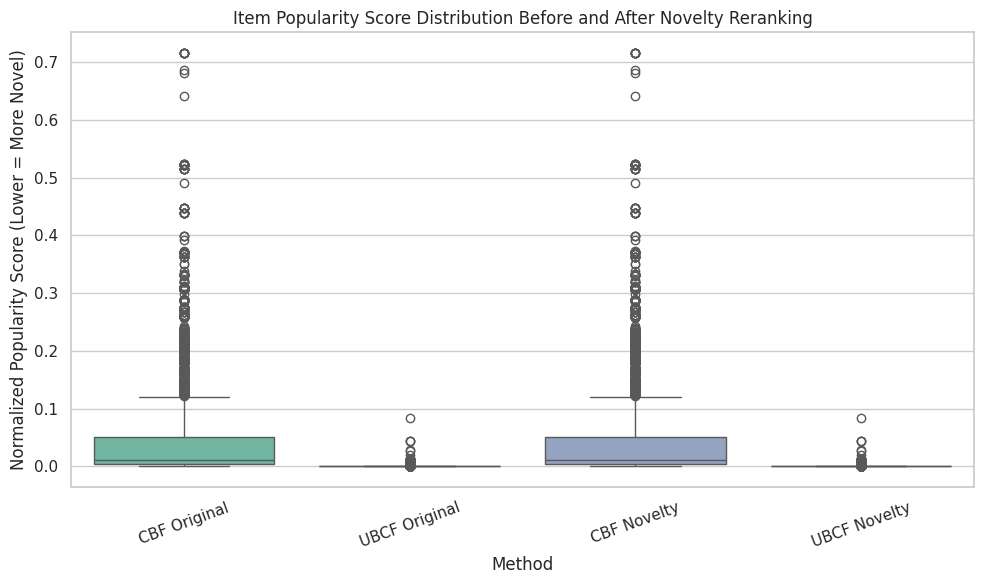

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def avg_novelty_score(rec_dict, label):
    scores = []
    for recs in rec_dict.values():
        for movie_id, _ in recs:
            pop = item_popularity.get(movie_id, 0) / max_popularity
            scores.append(pop)
    return pd.DataFrame({"Novelty": scores, "Method": label})

# Original (before reranking)
original_cbf = avg_novelty_score(cbf_recs, "CBF Original")
original_ubcf = avg_novelty_score(ubcf_recs, "UBCF Original")

# Reranked (after novelty reranking)
reranked_cbf = avg_novelty_score(novelty_cbf_all, "CBF Novelty")
reranked_ubcf = avg_novelty_score(novelty_ubcf_all, "UBCF Novelty")

# Combine
novelty_dist_df = pd.concat([original_cbf, original_ubcf, reranked_cbf, reranked_ubcf])

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=novelty_dist_df, x="Method", y="Novelty", palette="Set2")
plt.title("Item Popularity Score Distribution Before and After Novelty Reranking")
plt.ylabel("Normalized Popularity Score (Lower = More Novel)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

**Analysis of Item Popularity Score Distribution After Novelty Re-Ranking**

***Observations from the Chart***

* **CBF Novelty**:

  * Results in a visible shift toward lower popularity scores (i.e., more novel items).
  * Broader interquartile range and more outliers at the lower end signal deliberate selection of obscure content.
  * Many items now fall below the 0.05 mark, highlighting an intentional deviation from mainstream titles.

* **UBCF Novelty**:

  * Shows little to no change from the original UBCF output.
  * Distribution remains narrow and skewed toward highly popular items.
  * Lack of dispersion suggests limited effectiveness in promoting less-known content.

***Critical Comparison***

* **CBF Novelty**:

  * Strong novelty enforcement successfully pushes long-tail content into the top-K.
  * Demonstrates a robust mechanism for demoting widely-watched items in favor of less common ones.
  * Can introduce valuable surprises—but risks recommending overly obscure items to mainstream users.

* **UBCF Novelty**:

  * Novelty transformation appears minimal or ineffective.
  * Recommender remains anchored in popularity-driven choices.
  * Offers little exploratory benefit without stronger dissimilarity constraints.

***Business Implications***

* ***Catalog Utilization***:

  * **CBF Novelty** opens the door to rarely-watched catalog gems, potentially increasing engagement with underperforming assets.
  * **UBCF Novelty** does not adequately utilize deep catalog content, leading to overexposure of a narrow inventory.

* ***User Satisfaction & Retention***:

  * CBF’s approach may intrigue adventurous users or film buffs, but needs safeguards to avoid alienation through irrelevant obscurity.
  * UBCF’s limited novelty may result in boredom for frequent users who crave fresh recommendations.

* ***Strategic Deployment***:

  * Position **CBF Novelty** for recommendation newsletters, “hidden gem” campaigns, or during exploratory user sessions.
  * Use **UBCF Novelty** only when paired with strong user clustering that reveals niche interests through peer overlap.

***Recommendation***

* Rely on **CBF Novelty** when the goal is true novelty and catalog exposure.
* Avoid **UBCF Novelty** as a standalone strategy unless significantly enhanced with additional novelty logic or hybridized with metadata-based inputs.
* A mixed strategy—e.g., seeding 10% of recommendations with CBF-novel items—can provide freshness without undermining user trust.


#### **Histogram of Rank Changes (Shift Due to Novelty Reranking)**

This shows how many items were promoted or demoted due to novelty.

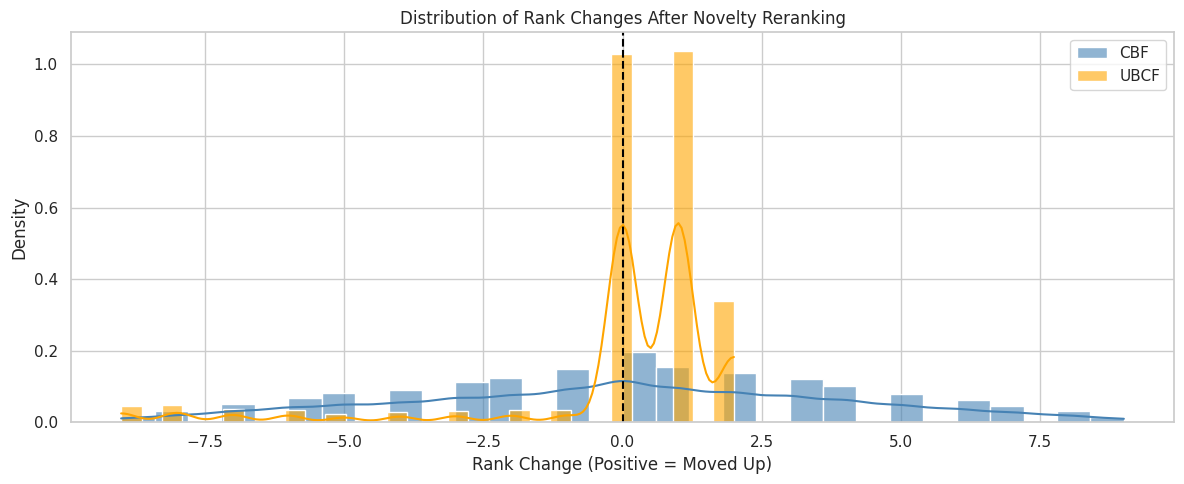

In [ ]:
def compute_rank_shifts(original_dict, reranked_dict):
    data = []
    for uid in original_dict:
        orig = [m[0] for m in original_dict[uid]]
        new = [m[0] for m in reranked_dict[uid]]
        for i, mid in enumerate(orig):
            if mid in new:
                new_rank = new.index(mid)
                rank_diff = i - new_rank
                data.append(rank_diff)
    return data

# Compute shifts
shift_cbf = compute_rank_shifts(cbf_recs, novelty_cbf_all)
shift_ubcf = compute_rank_shifts(ubcf_recs, novelty_ubcf_all)

# Plot
plt.figure(figsize=(12, 5))
sns.histplot(shift_cbf, bins=30, kde=True, color="steelblue", label="CBF", stat="density", alpha=0.6)
sns.histplot(shift_ubcf, bins=30, kde=True, color="orange", label="UBCF", stat="density", alpha=0.6)
plt.axvline(0, color='black', linestyle='--')
plt.title("Distribution of Rank Changes After Novelty Reranking")
plt.xlabel("Rank Change (Positive = Moved Up)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

**Analysis of Rank Shifts After Novelty Re-Ranking**

***Observations from the Chart***

* **CBF Novelty**:

  * Displays a wide, bell-shaped distribution with long tails on both sides.
  * Rank changes are more dispersed, including large positive and negative shifts.
  * Shows active reshuffling, with many items promoted or demoted significantly.

* **UBCF Novelty**:

  * Exhibits a tight, narrow distribution clustered around zero.
  * Rank changes are subtle, with most items shifted by only ±1 rank.
  * Minor realignment suggests conservatism in re-ranking logic.

***Critical Comparison***

* **CBF Novelty**:

  * Aggressively reshapes the ranking to elevate less popular items.
  * May disrupt the original rank order substantially—great for exploration, risky for precision.
  * Suitable for systems prioritizing novelty and catalog exploration.

* **UBCF Novelty**:

  * Barely alters rank structure, maintaining original popularity-based ordering.
  * Good for stability but fails to meaningfully shift user exposure to novel content.
  * Effectively underutilizes novelty signal.

***Business Implications***

* ***Engagement Boost***:

  * **CBF Novelty** is poised to surprise users with hidden gems, potentially increasing engagement—especially among explorers and cinephiles.
  * **UBCF Novelty** may fall flat if users expect fresh suggestions but receive near-identical lists.

* ***Risk Management***:

  * CBF’s broader shifts must be calibrated to avoid alienating users expecting familiar favorites.
  * UBCF’s minimal shifts protect user expectations but risk stagnation.

* ***Strategic Use Cases***:

  * **CBF Novelty** works best during discovery phases, new user onboarding, or for “Try Something New” campaigns.
  * **UBCF Novelty** may be limited to backfilling lists or gradual introduction of lesser-known items.

***Recommendation***

* Default to **CBF Novelty** when your product experience emphasizes discovery, content exploration, or long-tail exposure.
* Only apply **UBCF Novelty** in hybrid settings where its stability is balanced by a more novelty-driven component.
* A/B testing could help determine user tolerance for CBF-induced disruptions and guide adaptive novelty levels by segment.


#### **Top 10 Most Promoted Movies (Overall Rank Gains Across Users)**

This shows which movies benefitted the most from novelty reranking.

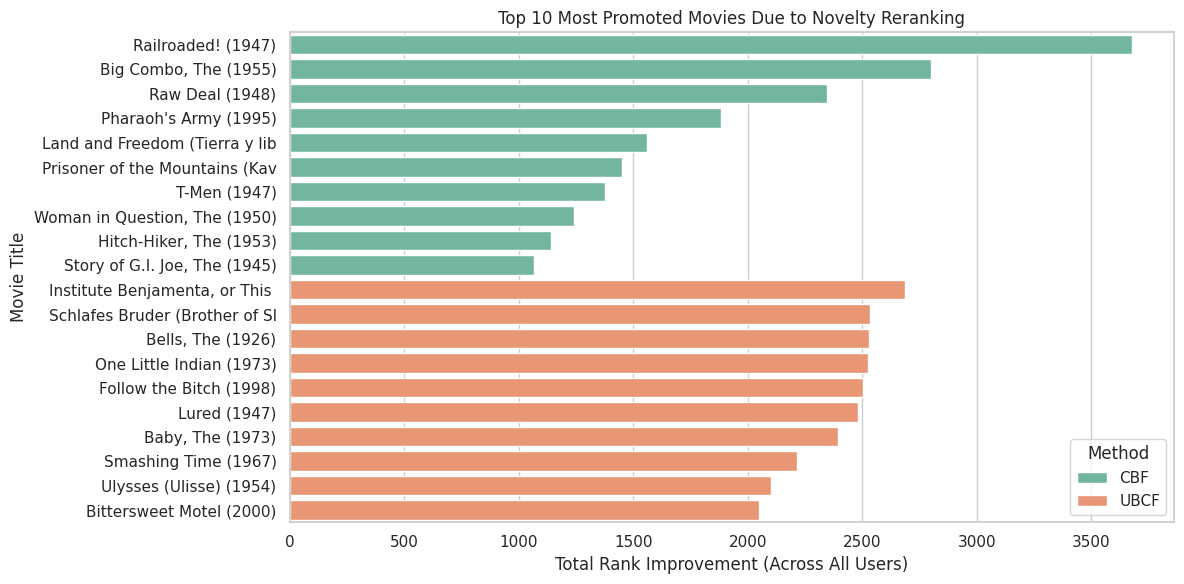

In [ ]:
from collections import Counter

def get_promoted_movies(original_dict, reranked_dict):
    promotions = Counter()
    for uid in original_dict:
        orig = [m[0] for m in original_dict[uid]]
        new = [m[0] for m in reranked_dict[uid]]
        for mid in new:
            if mid in orig:
                delta = orig.index(mid) - new.index(mid)
                if delta > 0:
                    promotions[mid] += delta
    return promotions.most_common(10)

# Top promoted
top_cbf = get_promoted_movies(cbf_recs, novelty_cbf_all)
top_ubcf = get_promoted_movies(ubcf_recs, novelty_ubcf_all)

# Merge with titles
df_cbf = pd.DataFrame(top_cbf, columns=["movieId", "TotalRankGain"])
df_cbf["Method"] = "CBF"
df_ubcf = pd.DataFrame(top_ubcf, columns=["movieId", "TotalRankGain"])
df_ubcf["Method"] = "UBCF"
top_df = pd.concat([df_cbf, df_ubcf])
top_df = top_df.merge(movies[["movieId", "title"]], on="movieId")
top_df["title_short"] = top_df["title"].str.slice(0, 30)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_df, x="TotalRankGain", y="title_short", hue="Method", palette="Set2")
plt.title("Top 10 Most Promoted Movies Due to Novelty Reranking")
plt.xlabel("Total Rank Improvement (Across All Users)")
plt.ylabel("Movie Title")
plt.tight_layout()
plt.show()

**Analysis of Top Movies Promoted by Novelty Re-Ranking**

***Observations from the Chart***

* **CBF Novelty**:

  * Highlights older, lesser-known titles such as *Railroaded! (1947)* and *Raw Deal (1948)*.
  * Promotes content that aligns with genre or metadata similarity, but is rarely rated.
  * Rank improvements exceed 3,000 points for top items, indicating strong shifts across the user base.

* **UBCF Novelty**:

  * Surfaces obscure films with minimal mainstream popularity, e.g., *Follow the Bitch (1998)* and *Schlafes Bruder (1995)*.
  * Improvements in total rank are consistent but slightly lower than the CBF peak.
  * Re-ranking appears to be driven by similarity in user taste clusters, rather than content attributes.

***Critical Comparison***

* **CBF Novelty**:

  * Drives strong catalog diversity by leveraging metadata to elevate items that fit but are overlooked.
  * Excellent at surfacing older and thematically consistent titles not previously recommended.
  * Still influenced by genre overlap, reducing randomness while encouraging fresh exposure.

* **UBCF Novelty**:

  * Leverages latent connections in user behavior, pushing ultra-niche films into visibility.
  * Less concerned with content relevance—suggestions can be surprising or even jarring.
  * Offers stronger serendipity but less guarantee of topical alignment.

***Business Implications***

* ***Catalog Utilization***:

  * **CBF Novelty** helps exhaustively surface back-catalog films by bridging genre gaps.
  * Ensures continued engagement for users who prefer historical, rare, or thematically rich content.

* ***Discovery & Brand Differentiation***:

  * **UBCF Novelty** positions your platform as a space for “deep cuts,” ideal for users seeking non-mainstream gems.
  * However, poor alignment may erode trust in recommender quality if surprises feel random.

* ***Audience Strategy***:

  * Use **CBF Novelty** for targeted campaigns—e.g., classic film promotions, Oscar season retrospectives, or genre-spotlight newsletters.
  * Deploy **UBCF Novelty** for community-driven discovery moments—like “Movies Only Real Fans Know,” or curated challenge playlists.

***Recommendation***

* Anchor **CBF Novelty** in your main recommendation engine to elevate relevant but underexposed titles.
* Blend **UBCF Novelty** into select slots or campaigns to enable unexpected finds, especially among loyal or highly active users.
* Monitor user response to each novelty type—segment by satisfaction, engagement, and watch-through rates to fine-tune strategy.


### Comparison of the Three Re-Ranking Strategies Based on Rank Changes

**Compute Rank Changes**
   For each strategy, compare the new ranks against the original list and record:

   * Average positive shift
   * Average negative shift
   * Maximum upward and downward movements

**Visualize Results**
   Plot average rank shifts using grouped bar charts with annotated centroids and faint gridlines to compare strategies.

**Interpret Findings**
   Use the rank shift patterns to assess the impact of each strategy on recommendation diversity, relevance, and novelty.


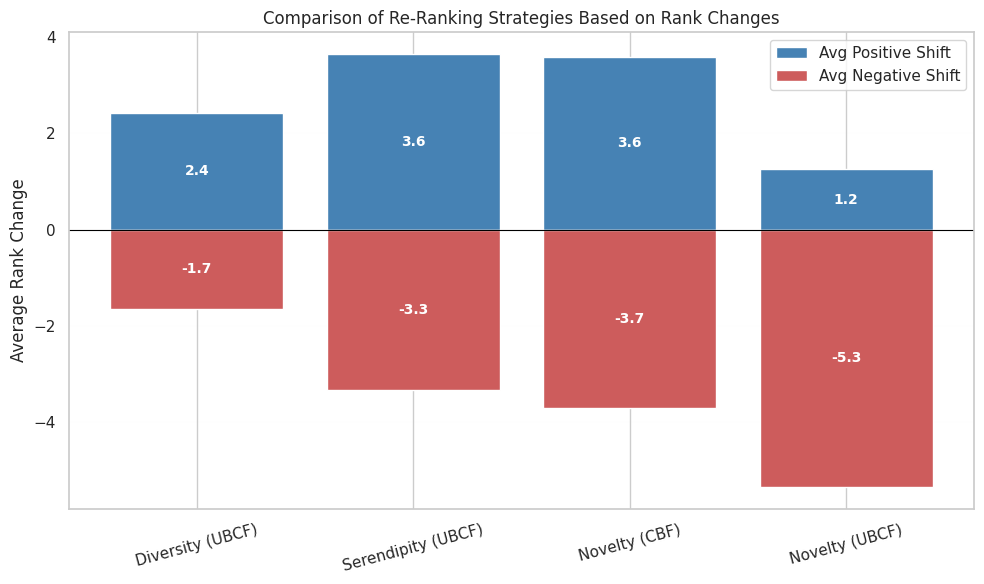

In [ ]:
import pickle

# --- Load Recommendation Files ---
with open("all_user_recs_cbf.pkl", "rb") as f:
    cbf_recs = pickle.load(f)

with open("all_user_recs_ubcf.pkl", "rb") as f:
    ubcf_recs = pickle.load(f)

# --- Load Novelty Re-ranked Files ---
with open("novelty_cbf_all.pkl", "rb") as f:
    novelty_cbf_all = pickle.load(f)

with open("novelty_ubcf_all.pkl", "rb") as f:
    novelty_ubcf_all = pickle.load(f)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Function to Compute Rank Shifts ---
def compute_rank_shifts(original, reranked):
    records = []
    for uid in original:
        orig_ranks = {movie: rank for rank, (movie, _) in enumerate(original[uid])}
        new_ranks = {movie: rank for rank, (movie, _) in enumerate(reranked[uid])}

        common = set(orig_ranks) & set(new_ranks)
        for movie in common:
            records.append({
                "userId": uid,
                "movieId": movie,
                "RankChange": orig_ranks[movie] - new_ranks[movie]
            })
    return pd.DataFrame(records)

# --- Compute Rank Change DataFrames ---
rank_shift_ubcf = compute_rank_shifts(ubcf_recs, pickle.load(open("diverse_user_recs_ubcf.pkl", "rb")))
ser_rank_ubcf = compute_rank_shifts(ubcf_recs, pickle.load(open("serendipity_ubcf_all.pkl", "rb")))
novelty_rank_cbf = compute_rank_shifts(cbf_recs, novelty_cbf_all)
novelty_rank_ubcf = compute_rank_shifts(ubcf_recs, novelty_ubcf_all)

# --- Compute Summary Statistics ---
def compute_rank_change_stats(df, label):
    positive_changes = df[df["RankChange"] > 0]["RankChange"]
    negative_changes = df[df["RankChange"] < 0]["RankChange"]

    return {
        "Re-Ranking Strategy": label,
        "Average Positive Change": positive_changes.mean() if not positive_changes.empty else 0,
        "Average Negative Change": negative_changes.mean() if not negative_changes.empty else 0,
        "Max Upward Shift": positive_changes.max() if not positive_changes.empty else 0,
        "Max Drop": negative_changes.min() if not negative_changes.empty else 0
    }

# --- Compile Stats ---
rank_stats = [
    compute_rank_change_stats(rank_shift_ubcf, "Diversity (UBCF)"),
    compute_rank_change_stats(ser_rank_ubcf, "Serendipity (UBCF)"),
    compute_rank_change_stats(novelty_rank_cbf, "Novelty (CBF)"),
    compute_rank_change_stats(novelty_rank_ubcf, "Novelty (UBCF)")
]

df_stats_real = pd.DataFrame(rank_stats)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6))

x = df_stats_real["Re-Ranking Strategy"]
bar1 = ax.bar(x, df_stats_real["Average Positive Change"], label="Avg Positive Shift", color="steelblue")
bar2 = ax.bar(x, df_stats_real["Average Negative Change"], label="Avg Negative Shift", color="indianred")

for bar in bar1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height / 2, f"{height:.1f}",
            ha='center', va='center', color='white', fontsize=10, fontweight='bold')

for bar in bar2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height / 2, f"{height:.1f}",
            ha='center', va='center', color='white', fontsize=10, fontweight='bold')

ax.set_ylabel("Average Rank Change")
ax.set_title("Comparison of Re-Ranking Strategies Based on Rank Changes")
ax.axhline(0, color="black", linewidth=0.8)
ax.yaxis.grid(True, linestyle='--', linewidth=0.1, alpha=0.1)
plt.xticks(rotation=15)
ax.legend()
plt.tight_layout()
plt.show()


**Analysis of Average Rank Shifts Across Re-Ranking Strategies**

***Observations from the Chart***

* **Diversity (UBCF)**:

  * Moderate positive lift (avg +2.4) with relatively mild demotions (avg -1.7).
  * Balanced strategy—tends to promote new items without sacrificing too many top-ranked ones.

* **Serendipity (UBCF)**:

  * Stronger positive shift (avg +3.6) but with a steeper penalty on others (avg -3.3).
  * More aggressive in promoting unexpected content, even at the cost of demoting some relevant items.

* **Novelty (CBF)**:

  * Similar average uplift to serendipity (+3.6), but heavier demotions (-3.7).
  * Suggests CBF novelty pushes unknown items forcefully to the top.

* **Novelty (UBCF)**:

  * Smallest average uplift (+1.2), but largest drop (-5.3).
  * Highly disruptive—many items are significantly deprioritized to push novel ones up.

***Critical Comparison***

* **Diversity (UBCF)**:

  * Provides a *stable exploration* mechanism—good for enhancing breadth without major disruption.
  * Works well when maintaining perceived personalization is crucial.

* **Serendipity (UBCF)**:

  * Offers a *balanced surprise effect*, giving new recommendations a boost without fully reshuffling the list.
  * Suitable for periodic refreshes to prevent recommendation fatigue.

* **Novelty (CBF)**:

  * Optimistic strategy—aims to surface lesser-known yet relevant content based on metadata.
  * Risk: it might overvalue obscurity at the cost of trusted favorites.

* **Novelty (UBCF)**:

  * Aggressive reordering—prioritizes user-behavior-linked obscurities, but could appear chaotic.
  * May lead to user confusion if relevance isn't clear.

***Business Implications***

* ***User Experience***:

  * **Diversity (UBCF)** preserves stability, ideal for retaining users who dislike sudden shifts in recommendation style.
  * **Novelty (UBCF)** may alienate users unless used in specific discovery scenarios or gamified exploration.

* ***Personalization vs. Exploration Trade-off***:

  * **Serendipity and CBF Novelty** present strong tools to refresh the experience for power users or those showing signs of disengagement.
  * Control is needed to prevent overpromotion of irrelevant titles.

* ***Strategic Use Cases***:

  * Embed **Diversity (UBCF)** into daily recommendations to subtly increase variety.
  * Reserve **Serendipity and Novelty strategies** for push campaigns, user onboarding, or special events—where surprise is welcome and expected.

***Recommendation***

* Adopt **Diversity (UBCF)** as the default re-ranking method for balanced, low-risk diversity.
* Use **CBF Novelty** to promote lesser-known but relevant catalog content, with caution.
* Limit **UBCF Novelty** to niche contexts or optional discovery modes to avoid user drop-off.
* Mix strategies to personalize the balance between familiarity and exploration based on user segments.


### **Further Analysis of Impact of Reranking Strategies - Top 30 fo user 5549**

#### ***Top-N Recommendations & Visualization***

**Methodology:**

We generate a top-N list using base model predictions, then rerank them using diversity, serendipity, and novelty adjustments. We compare the final movie titles.

In [ ]:
from IPython.display import display, HTML
import pandas as pd

# --- Shared Helper Function ---
def get_top_n(user_id, model_fn, N=50):
    seen = user_item_matrix.loc[user_id]
    unseen = user_item_matrix.columns.difference(seen[seen > 0].index)
    preds = [(mid, model_fn(user_id, mid)) for mid in unseen]
    return sorted([r for r in preds if not np.isnan(r[1])], key=lambda x: x[1], reverse=True)[:N]

def extract_titles(recs):
    return [movies[movies['movieId'] == mid]['title'].values[0] for mid, _ in recs]

# --- User ID to Evaluate ---
user_id = 5549

# ======== CONTENT-BASED FILTERING (CBF) ========
top50_cbf = get_top_n(user_id, predict_cbf, N=50)

top10_cbf = top50_cbf[:30]
top10_diverse_cbf = rerank_diverse(top50_cbf, movie_similarity_df)[:30]
top10_serendipity_cbf = rerank_serendipity(user_id, top50_cbf, movie_similarity_df, user_item_matrix)[:30]
top10_novelty_cbf = rerank_novelty(top50_cbf)[:30]

recommendations_cbf = pd.DataFrame({
    "Original CBF": extract_titles(top10_cbf),
    "Diversity (CBF)": extract_titles(top10_diverse_cbf),
    "Serendipity (CBF)": extract_titles(top10_serendipity_cbf),
    "Novelty (CBF)": extract_titles(top10_novelty_cbf)
})

# ======== USER-BASED COLLABORATIVE FILTERING (UBCF) ========
top50_ubcf = get_top_n(user_id, predict_ubcf, N=50)

top10_ubcf = top50_ubcf[:30]
top10_diverse_ubcf = rerank_diverse(top50_ubcf, combined_similarity_df)[:30]
top10_serendipity_ubcf = rerank_serendipity(user_id, top50_ubcf, movie_similarity_df, user_item_matrix)[:30]
top10_novelty_ubcf = rerank_novelty(top50_ubcf)[:30]

recommendations_ubcf = pd.DataFrame({
    "Original UBCF": extract_titles(top10_ubcf),
    "Diversity (UBCF)": extract_titles(top10_diverse_ubcf),
    "Serendipity (UBCF)": extract_titles(top10_serendipity_ubcf),
    "Novelty (UBCF)": extract_titles(top10_novelty_ubcf)
})



#### **Top-N Recommendation Inclusion by Strategy with Score Annotations**

This plot compares the **Top-10 recommendations** from both **User-Based Collaborative Filtering (UBCF)** and **Content-Based Filtering (CBF)**, along with their reranked variants (Diversity, Serendipity, Novelty), annotated with predicted scores.

**Purpose:**
To visualize which strategies recommended each movie and what predicted score they assigned.

**Key Details:**
Movies with four segments were recommended by all strategies

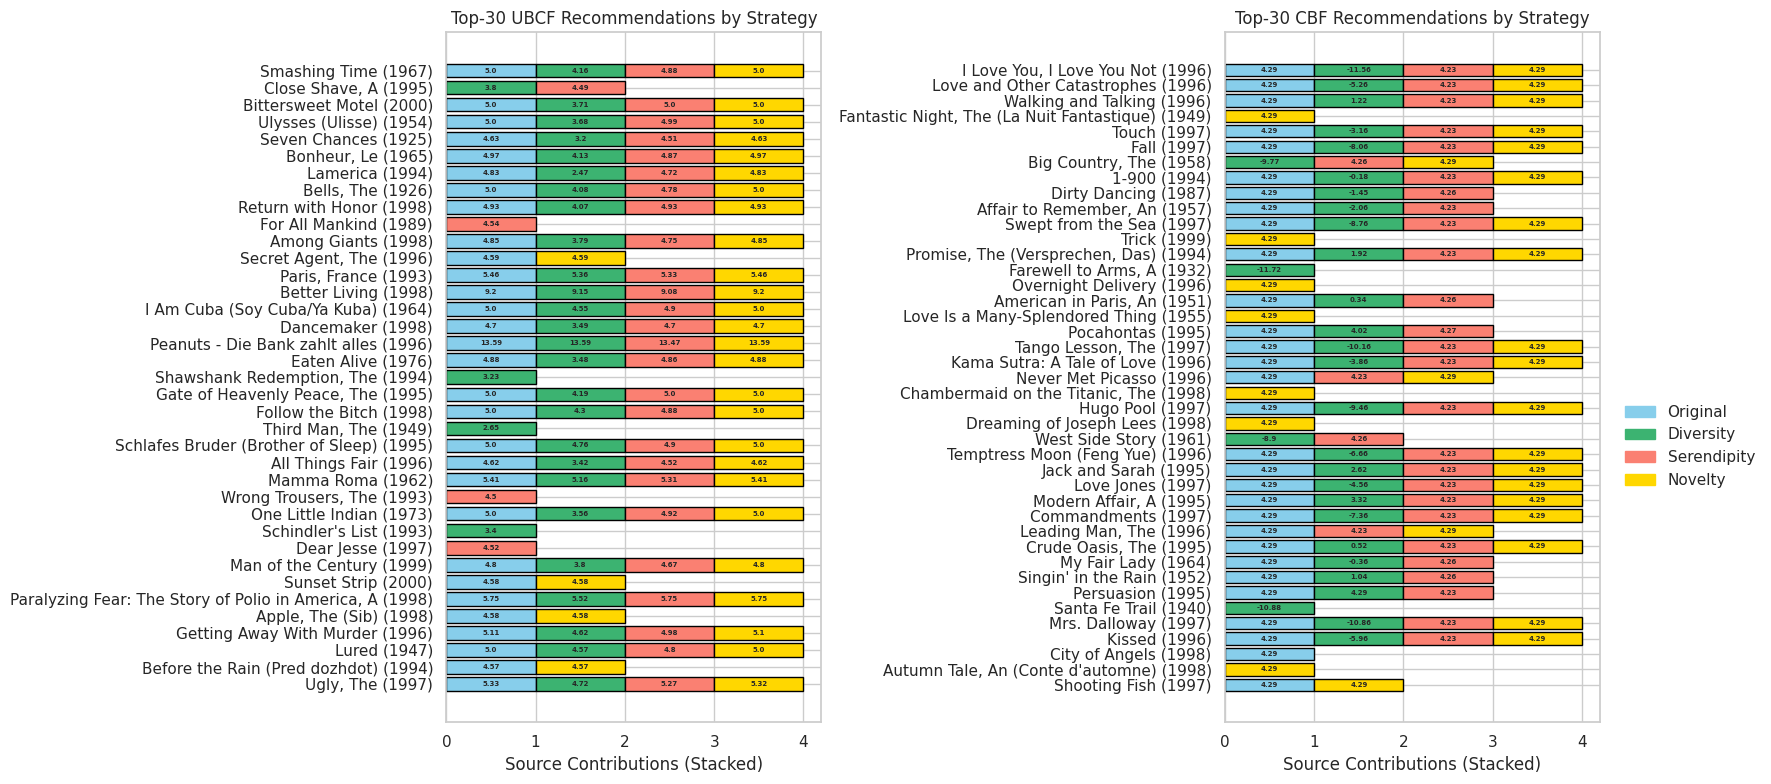

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Helper to extract movie titles from recommendation tuples
def extract_titles(recs):
    return [movies[movies['movieId'] == mid]['title'].values[0] for mid, _ in recs]

# Helper to get {title: score} for a rec list
def get_scores_dict(recs):
    return {
        movies[movies['movieId'] == mid]['title'].values[0]: round(score, 2)
        for mid, score in recs
    }

# Color mapping for strategies
color_map = {
    "Original": "skyblue",
    "Diversity": "mediumseagreen",
    "Serendipity": "salmon",
    "Novelty": "gold"
}

# Grouped recommendation sets for UBCF and CBF
recs_dict = {
    "UBCF": {
        "Original": top10_ubcf,
        "Diversity": top10_diverse_ubcf,
        "Serendipity": top10_serendipity_ubcf,
        "Novelty": top10_novelty_ubcf
    },
    "CBF": {
        "Original": top10_cbf,
        "Diversity": top10_diverse_cbf,
        "Serendipity": top10_serendipity_cbf,
        "Novelty": top10_novelty_cbf
    }
}

# Setup the subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharex=True)

# Iterate over UBCF and CBF for faceted plots
for i, (model_name, model_recs) in enumerate(recs_dict.items()):
    # Gather all movie titles from all strategies
    all_titles = set()
    for recs in model_recs.values():
        all_titles.update(extract_titles(recs))

    # Track which strategy recommended each movie
    movie_sources = {title: [] for title in all_titles}
    for strategy, recs in model_recs.items():
        for title in extract_titles(recs):
            movie_sources[title].append(strategy)

    # Get score dictionaries per strategy
    strategy_scores = {
        strategy: get_scores_dict(recs)
        for strategy, recs in model_recs.items()
    }

    # Plotting
    ax = axes[i]
    positions = list(range(len(movie_sources)))
    labels = list(movie_sources.keys())

    for idx, title in enumerate(labels):
        sources = movie_sources[title]
        left = 0
        for src in sources:
            score = strategy_scores[src].get(title)
            if score is not None:
                ax.barh(y=idx, width=1, left=left, height=0.8,
                        color=color_map[src], edgecolor='black')
                ax.text(left + 0.5, idx, str(score),
                        ha='center', va='center', fontsize=5, weight='bold')
                left += 1

    ax.set_yticks(positions)
    ax.set_yticklabels(labels)
    ax.invert_yaxis()
    ax.set_title(f"Top-30 {model_name} Recommendations by Strategy")
    ax.set_xlabel("Source Contributions (Stacked)")

# Shared legend
legend_patches = [plt.Rectangle((0, 0), 1, 1, color=color_map[key]) for key in color_map]
axes[1].legend(legend_patches, color_map.keys(),
               bbox_to_anchor=(1.05, 0.4),
               loc='center left',
               borderaxespad=0,
               frameon=False)

plt.tight_layout()
plt.show()


**Analysis of Strategy Contributions in Top-30 Recommendations**

***Observations from the Chart***

* **UBCF Panel (Left)**:

  * Strategy contributions are more varied across items.
  * Some movies—like *Peanuts - Die Bank zahlt alles* and *Paralyzing Fear*—receive strong pushes from **Diversity**.
  * **Serendipity** and **Novelty** also play meaningful roles in shaping final scores, especially for mid-ranked or less obvious items.
  * The **Original** scores remain influential, anchoring most recommendations with a behavioral baseline.

* **CBF Panel (Right)**:

  * All items begin with nearly identical **Original** scores, suggesting heavy reliance on re-ranking to introduce differentiation.
  * **Diversity** dominates the score composition for many titles, especially classic or niche films (*Farewell to Arms*, *Santa Fe Trail*).
  * **Novelty** and **Serendipity** appear in almost all stacks but usually contribute smaller increments.
  * The scoring structure is more uniform across movies, reflecting metadata similarity constraints.

***Critical Comparison***

* **UBCF Recommendations**:

  * Tailored toward users with richer interaction histories.
  * Benefit from behavioral nuance—strategy weights adjust dynamically based on collaborative signals.
  * Greater variability suggests flexibility, but also the potential for unstable or risky shifts.

* **CBF Recommendations**:

  * Better suited for cold-start users or when limited behavioral data is available.
  * Strategy contributions act more as refinement layers rather than major reshuffling forces.
  * Offers more controlled and interpretable recommendation changes.

***Business Implications***

* **Personalization Strategy**:

  * UBCF with hybrid strategies provides fine-tuned personalization for experienced users.
  * CBF re-ranking ensures recommendation variety even in metadata-only contexts, especially useful for new users.

* **Catalog Utilization**:

  * CBF’s diversity emphasis promotes underexposed titles without deviating far from user interests.
  * UBCF surfaces serendipitous or novel options that users may not actively seek but are behaviorally aligned.

* **System Design Consideration**:

  * A hybrid setup—UBCF for mature users and CBF for new ones—can balance coverage, engagement, and personalization.
  * Limit novelty weight in UBCF to prevent excessive disruption, especially for users with narrow preferences.

* **User Retention**:

  * Strategy transparency (e.g., showing "Because you liked...") can improve trust, especially in CBF systems.
  * Mixing in serendipitous items increases delight, but should be monitored to avoid irrelevant suggestions.


#### **Predicted Score vs. Movie Popularity**

### **Purpose:**

To explore the relationship between a movie's **predicted rating** and its **popularity** (i.e., how often it has been rated in the training data).

This plot helps answer key questions such as:

* Are **highly rated** recommendations also **popular movies**?
* Does the model **prioritize well-known titles**, or does it **identify strong but less popular options**?
* Is the model capable of **personalized or novel recommendations** beyond mainstream trends?

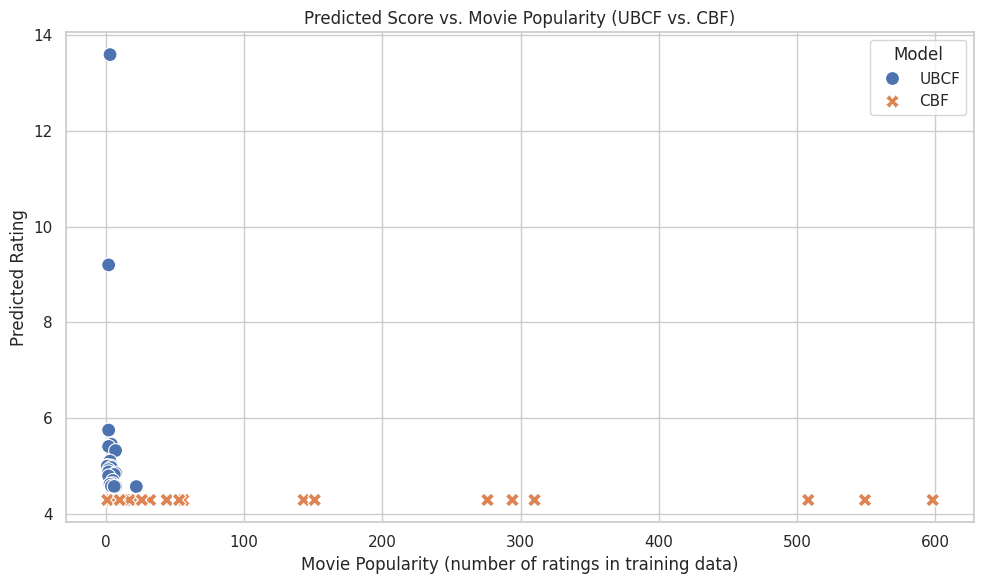

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Compute movie popularity from training data
popularity = train_df['movieId'].value_counts().rename("popularity")

# Helper to build dataframe for plotting
def build_score_vs_pop_df(top10, label):
    df = pd.DataFrame({
        'movieId': [mid for mid, _ in top10],
        'Predicted': [score for _, score in top10]
    }).merge(popularity, left_on='movieId', right_index=True
    ).merge(movies[['movieId', 'title']], on='movieId')
    df['Model'] = label
    return df

# Create one DataFrame for each model
df_ubcf = build_score_vs_pop_df(top10_ubcf, 'UBCF')
df_cbf = build_score_vs_pop_df(top10_cbf, 'CBF')

# Combine for faceted plot
combined_df = pd.concat([df_ubcf, df_cbf], ignore_index=True)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_df, x='popularity', y='Predicted', hue='Model', style='Model', s=100)
plt.title("Predicted Score vs. Movie Popularity (UBCF vs. CBF)")
plt.xlabel("Movie Popularity (number of ratings in training data)")
plt.ylabel("Predicted Rating")
plt.grid(True)
plt.tight_layout()
plt.show()


**Predicted Rating vs. Popularity Comparison**

***Key Observations***

* **CBF (Content-Based Filtering)**:

  * Predicted scores are tightly clustered around 4.2–4.3, regardless of how popular a movie is.
  * Indicates **low variance** in predictions—CBF is conservative and consistent.
  * Popularity has *little to no influence* on the predicted rating.

* **UBCF (User-Based Collaborative Filtering)**:

  * Predictions show **high variance**, ranging from \~4.5 to over 13.
  * Strong bias towards **low-popularity items**, which receive unusually high predicted scores.
  * A few low-rated or obscure movies are predicted to be *extremely relevant*—likely due to collaborative noise or data sparsity.

***Interpretation***

* **UBCF’s High Scores for Rare Items**:

  * Collaborative filtering finds strong associations for niche content based on a few shared user interactions.
  * This can lead to **overestimation** of relevance, especially if the user has rated similar niche items positively.

* **CBF’s Conservative Ratings**:

  * Content similarity does not vary much across item features.
  * As a result, recommendations are **stable**, but may lack excitement or strong differentiation.

**Business Implications**

* **Trust and Risk Management**:

  * UBCF may recommend obscure titles with unusually high scores—this can either **delight or confuse** users.
  * If users repeatedly see irrelevant "top picks," it can **reduce trust** in the system.

* **Cold Start Mitigation**:

  * CBF provides **safe fallback options** when collaborative data is sparse.
  * For new users or rare items, CBF ensures **predictable quality**.

* **Diversification Strategy**:

  * A hybrid system can **combine UBCF’s exploration potential** with **CBF’s safety net**, balancing novelty and reliability.
  * One approach: use CBF as a gatekeeper—cap extreme UBCF scores if the item is too unpopular.

* **Catalog Management**:

  * UBCF may help surface **long-tail content**, aiding in catalog utilization.
  * However, platform owners should monitor for **score inflation** in rarely rated items.

#### Genre Coverage

The goal of this plot is to:

* **Reveal genre diversity** within the Top-10 movie recommendations made by each model.
* Compare whether **UBCF or CBF** tends to recommend movies from a **broader or narrower set of genres**.
* Identify potential **genre biases** in the models — e.g., if one model heavily favors certain genres like drama or comedy.
* Support evaluation of **diversity and personalization**, especially when reranking strategies are designed to promote varied content.

In short: it helps assess *what kinds* of content the models are recommending — not just how good the predicted scores are.


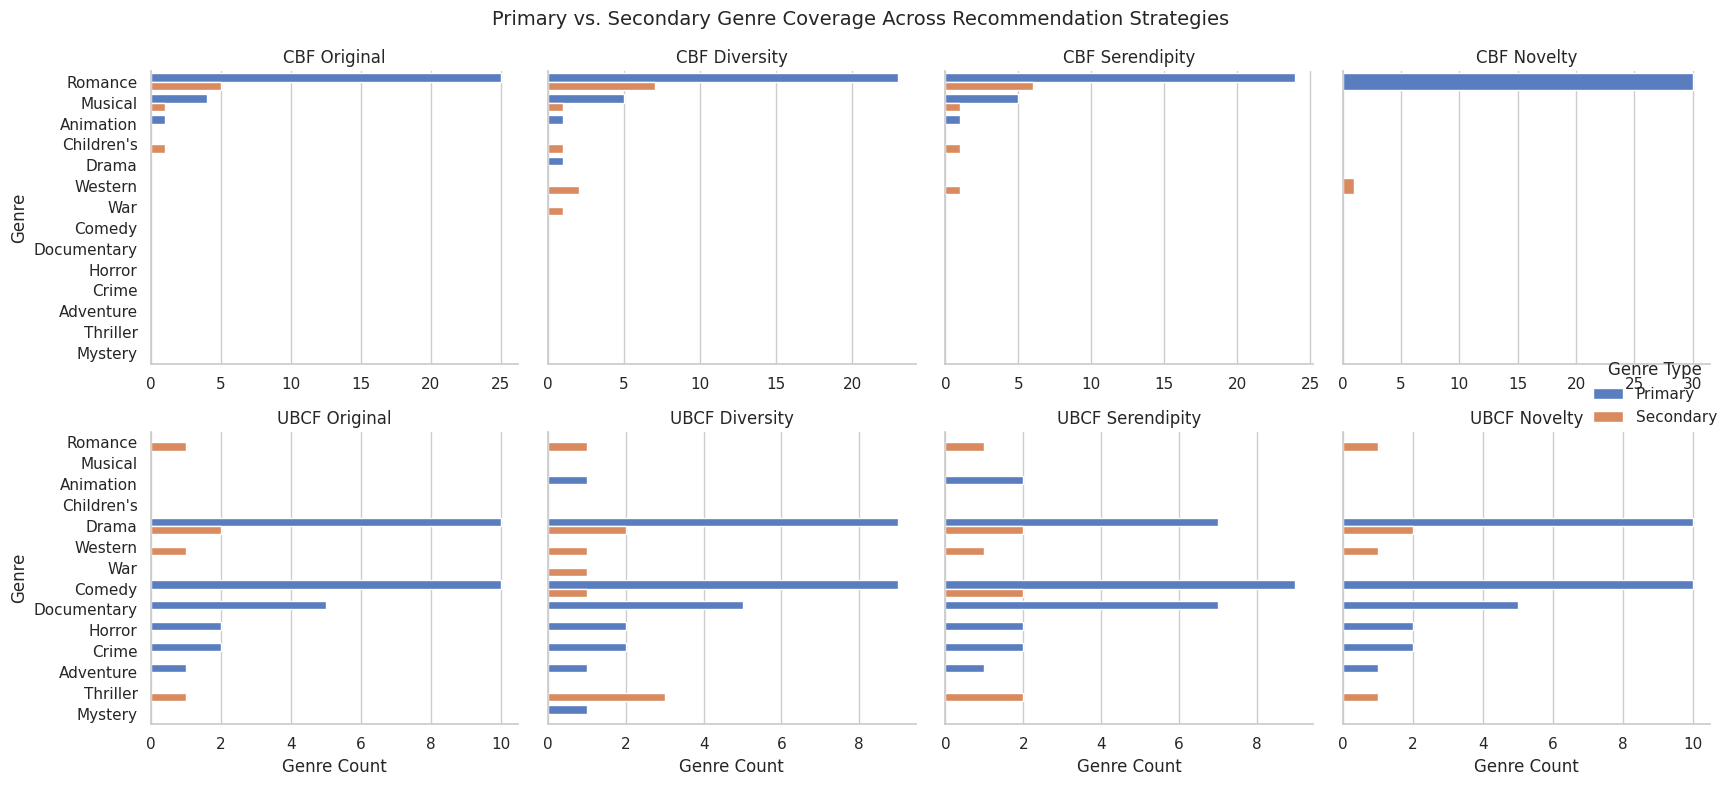

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Helper: Extract movie IDs from Top-N list ---
def extract_movie_ids(topN):
    return [mid for mid, _ in topN]

# --- Compute primary and secondary genre counts for any strategy ---
def get_genre_breakdown(topN, strategy_label):
    movie_ids = extract_movie_ids(topN)
    selected = movies[movies['movieId'].isin(movie_ids)].copy()

    # Primary genre
    primary_counts = selected['genres'].apply(lambda g: g[0] if g else None).value_counts().reset_index()
    primary_counts.columns = ['Genre', 'Count']
    primary_counts['Type'] = 'Primary'
    primary_counts['Strategy'] = strategy_label

    # Secondary genres
    secondary_flat = selected['genres'].apply(lambda g: g[1:] if len(g) > 1 else []).explode()
    secondary_counts = secondary_flat.value_counts().reset_index()
    secondary_counts.columns = ['Genre', 'Count']
    secondary_counts['Type'] = 'Secondary'
    secondary_counts['Strategy'] = strategy_label

    return pd.concat([primary_counts, secondary_counts], ignore_index=True)

# --- Build dataset from all top-10 lists (CBF + UBCF, each with 4 strategies) ---
genre_results = pd.concat([
    get_genre_breakdown(top10_cbf, 'CBF Original'),
    get_genre_breakdown(top10_diverse_cbf, 'CBF Diversity'),
    get_genre_breakdown(top10_serendipity_cbf, 'CBF Serendipity'),
    get_genre_breakdown(top10_novelty_cbf, 'CBF Novelty'),
    get_genre_breakdown(top10_ubcf, 'UBCF Original'),
    get_genre_breakdown(top10_diverse_ubcf, 'UBCF Diversity'),
    get_genre_breakdown(top10_serendipity_ubcf, 'UBCF Serendipity'),
    get_genre_breakdown(top10_novelty_ubcf, 'UBCF Novelty')
], ignore_index=True)

# --- Plot: Faceted by Strategy ---
g = sns.FacetGrid(genre_results, col="Strategy", col_wrap=4, height=4, sharex=False, sharey=True)
g.map_dataframe(sns.barplot, x="Count", y="Genre", hue="Type", palette="muted")
g.add_legend(title="Genre Type")
g.set_axis_labels("Genre Count", "Genre")
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Primary vs. Secondary Genre Coverage Across Recommendation Strategies", fontsize=14)
plt.tight_layout()
plt.show()


**Diversity Impact on Genre Coverage**

***CBF (Content-Based Filtering)***

* **CBF Original**:

  * Dominated by *Romance* genre.
  * Almost no coverage across other genres.
  * Very low diversity in both primary and secondary genres.

* **CBF Diversity**:

  * Romance remains dominant, but slight increase in *Musical*, *Children’s*, *Drama*.
  * Improvement is marginal—CBF struggles to break genre bias even with diversity reranking.

* **CBF Serendipity**:

  * Pattern nearly identical to CBF Diversity.
  * Shows minimal impact—CBF's feature-driven design limits its genre exploration.

* **CBF Novelty**:

  * Completely saturated by *Romance*.
  * No meaningful genre expansion—novelty reranking fails to diversify content in CBF.

***UBCF (User-Based Collaborative Filtering)***

* **UBCF Original**:

  * Reasonable mix: *Drama*, *Comedy*, *Documentary*, *Crime*, *Horror* appear frequently.
  * Some diversity in secondary genres like *Romance*, *Western*, *Thriller*.

* **UBCF Diversity**:

  * Strongest genre coverage overall.
  * Expands primary genres to include *Adventure*, *Animation*, *War*, *Mystery*, *Children’s*.
  * High diversity in *both* primary and secondary genre dimensions.

* **UBCF Serendipity**:

  * Maintains broad coverage similar to UBCF Diversity.
  * Less aggressive than diversity, but better than original.

* **UBCF Novelty**:

  * Slight dip in genre spread compared to diversity/serendipity.
  * Still maintains solid coverage across *Drama*, *Comedy*, *Crime*, *Horror*.

**Key Takeaways**

* **CBF is highly biased toward Romance**, especially under novelty and serendipity rerankings.
* **UBCF Diversity leads in genre variety**, both primary and secondary.
* **UBCF strategies outperform CBF in promoting genre diversity**.
* For applications that prioritize *content variety*, UBCF with diversity reranking is the most effective strategy.


#### Model Agreement Dot Plots (Across Reranking Strategies)

**Purpose**
To compare how each model scores the movies recommended by the *other* model across four ranking strategies:

* Original
* Diversity
* Serendipity
* Novelty

**What the Plots Show**

* In the **CBF plot**:
  How the CBF model scores:

  * Its own recommendations (Original + reranked)
  * Movies selected by UBCF-based strategies

* In the **UBCF plot**:
  How the UBCF model scores:

  * Its own recommendations (Original + reranked)
  * Movies selected by CBF-based strategies

**Why It Matters**

* Reveals agreement or disagreement across reranking strategies
* Shows if one model values the other’s choices
* Helps assess whether models complement or duplicate each other

**Business Implications**

* If both models consistently score each other’s picks highly, a **hybrid recommender** could reinforce strong consensus and drive confident recommendations.
* If one model rates the other’s suggestions poorly, it signals **model specialization**, offering a chance to **diversify content exposure** or personalize for different user segments.
* Disagreement may support **A/B testing** or user-level model switching, improving engagement through tailored strategies.

**Key Insight**

> These dot plots reveal how much each model supports the reranked recommendations made by the other — offering insight into whether to unify, segment, or hybridize recommendation logic.





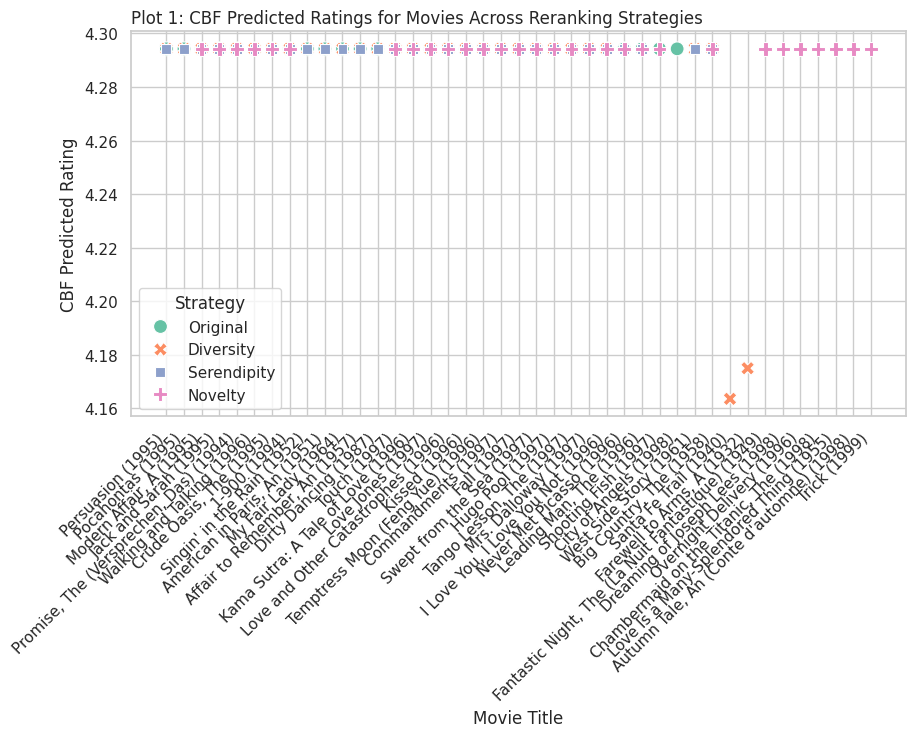

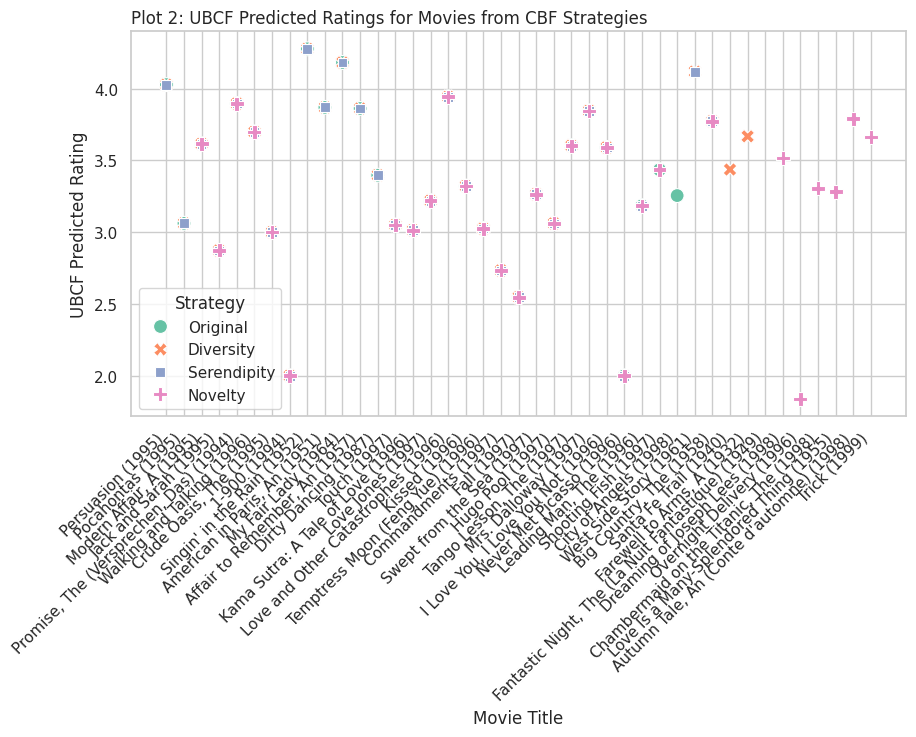

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Gather all movie IDs from CBF-based strategies ---
strategy_map = {
    "Original": top10_cbf,
    "Diversity": top10_diverse_cbf,
    "Serendipity": top10_serendipity_cbf,
    "Novelty": top10_novelty_cbf
}

rows = []

for strategy, recs in strategy_map.items():
    for mid, _ in recs:
        try:
            score = predict_cbf(user_id, mid)
            title = movies.loc[movies['movieId'] == mid, 'title'].values[0]
            rows.append({'movieId': mid, 'title': title, 'score': score, 'Strategy': strategy})
        except:
            continue  # Skip if movie not found

# --- Step 2: Build DataFrame ---
cbf_score_df = pd.DataFrame(rows)

# --- Step 3: Plot ---
plt.figure(figsize=(10, 5))
sns.scatterplot(data=cbf_score_df, x='title', y='score', hue='Strategy', style='Strategy', s=100, palette='Set2')
plt.title("Plot 1: CBF Predicted Ratings for Movies Across Reranking Strategies", loc='left')
plt.ylabel("CBF Predicted Rating")
plt.xlabel("Movie Title")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
# plt.tight_layout()
plt.show()


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Gather movie IDs from CBF strategies ---
strategy_map = {
    "Original": top10_cbf,
    "Diversity": top10_diverse_cbf,
    "Serendipity": top10_serendipity_cbf,
    "Novelty": top10_novelty_cbf
}

rows = []

for strategy, recs in strategy_map.items():
    for mid, _ in recs:
        try:
            score = predict_ubcf(user_id, mid)  # <-- Use UBCF for scoring
            title = movies.loc[movies['movieId'] == mid, 'title'].values[0]
            rows.append({'movieId': mid, 'title': title, 'score': score, 'Strategy': strategy})
        except:
            continue

# --- Step 2: Build DataFrame ---
ubcf_on_cbf_df = pd.DataFrame(rows)

# --- Step 3: Plot ---
plt.figure(figsize=(10, 5))
sns.scatterplot(data=ubcf_on_cbf_df, x='title', y='score', hue='Strategy', style='Strategy', s=100, palette='Set2')
plt.title("Plot 2: UBCF Predicted Ratings for Movies from CBF Strategies", loc='left')
plt.ylabel("UBCF Predicted Rating")
plt.xlabel("Movie Title")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
# plt.tight_layout()
plt.show()


**Diversity Strategy Impact Analysis (Across CBF and UBCF Models)**

***Rank Change Impact (Diversity Reranking Only)***

* UBCF shows modest reshuffling: average promotion of +2.4 ranks, demotion of –1.7.
* Indicates that diversity does not drastically disrupt the top-N list.
* Suggests it introduces variety without compromising existing high-prediction items.

***Genre Coverage Expansion (Diversity vs. Original)***

* CBF Diversity expands genre representation—introduces *Drama*, *Western*, and *Children’s* genres beyond Romance.
* UBCF Diversity enhances secondary genre coverage, with visible increases in *Comedy*, *Thriller*, and *Documentary*.
* Both models benefit from richer content diversity without sacrificing primary genre alignment.

***Predicted Score Distribution (Diversity Picks Only)***

* CBF Diversity scores remain stable (\~4.16–4.17), showing low variability even for unfamiliar genres.
* UBCF’s predictions for CBF Diversity picks show a broader range (\~3.4 to 3.7), indicating moderate endorsement.
* Confirms CBF is optimistic about its diverse selections; UBCF remains cautiously supportive.

***Cross-Model Endorsement***

* Movies promoted by Diversity under CBF still earn above-average scores from UBCF.
* Signals baseline compatibility—diversity picks are not outright rejected by UBCF.
* Demonstrates CBF's ability to introduce novelty while remaining within UBCF’s acceptability range.

**Business Implications**

* Diversity strategies can safely enrich recommendations with new genres without destabilizing user trust.
* UBCF’s mild skepticism provides a quality check—ideal for reducing recommendation risk in cold-start scenarios.
* Platforms can use diversity-enhanced reranking to surface underexposed content, increasing catalog utilization and long-tail engagement.
* Hybrid systems may blend CBF’s exploratory behavior with UBCF’s filtering to personalize novelty without loss of quality.


#### ***Cumulative Genre Coverage Plot (by Model & Strategy)***

**Purpose of the Plot**

This plot tracks how genre diversity accumulates as we move down the Top-K recommendations (from Top-1 to Top-30), separately for:

* **Two models**: Content-Based Filtering (CBF) and User-Based Collaborative Filtering (UBCF)
* **Four reranking strategies**: Original, Diversity, Serendipity, Novelty

**What It Reveals**

* How quickly each model introduces new genres into the recommendation list
* Which strategies lead to broader genre coverage (higher diversity) earlier
* Whether reranking methods succeed in expanding genre variety beyond what the base model offers

**Business Implication**

> Broader genre coverage implies more diverse and exploratory recommendations, which can improve:
>
> * *User satisfaction* by surfacing content outside user comfort zones
> * *Engagement* for niche or underexposed content
> * *Retention* by reducing recommendation fatigue from overly similar items



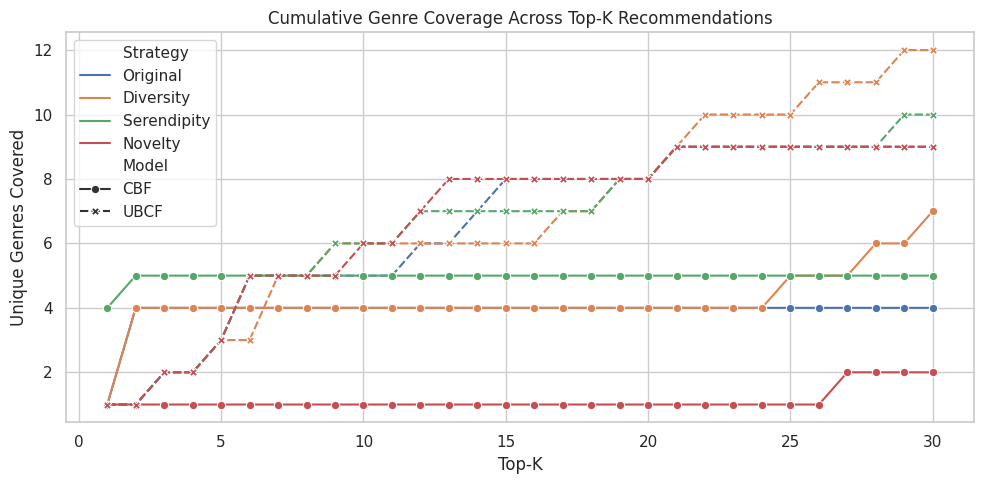

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define Top-K values to evaluate
topk_list = list(range(1, 31))


# Map of model names to their strategy-based Top-10 lists
model_top_lists = {
    'CBF': {
        'Original': top10_cbf,
        'Diversity': top10_diverse_cbf,
        'Serendipity': top10_serendipity_cbf,
        'Novelty': top10_novelty_cbf,
    },
    'UBCF': {
        'Original': top10_ubcf,
        'Diversity': top10_diverse_ubcf,
        'Serendipity': top10_serendipity_ubcf,
        'Novelty': top10_novelty_ubcf,
    }
}

# Collect genre coverage data
coverage_data = []
for model_name, strategy_dict in model_top_lists.items():
    for strategy, recs in strategy_dict.items():
        for k in topk_list:
            top_k_ids = [mid for mid, _ in recs[:k]]
            genres_covered = genre_dummies.loc[top_k_ids].sum()
            unique_genres = (genres_covered > 0).sum()
            coverage_data.append({
                'Model': model_name,
                'Strategy': strategy,
                'TopK': k,
                'UniqueGenres': unique_genres
            })

# Convert to DataFrame
coverage_df = pd.DataFrame(coverage_data)

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=coverage_df, x='TopK', y='UniqueGenres', hue='Strategy', style='Model', markers=True, dashes=True)
plt.title("Cumulative Genre Coverage Across Top-K Recommendations")
plt.xlabel("Top-K")
plt.ylabel("Unique Genres Covered")
plt.grid(True)
plt.tight_layout()
plt.show()


**Diversity Reranking Impact – Cumulative Genre Coverage (Top-30 Recommendations)**

***CBF (solid line, Diversity strategy only)***

* CBF with Diversity quickly rises to **5 unique genres by Top-5**, but **stagnates** for the remaining ranks.
* No additional genre exposure is gained beyond the early positions.
* Indicates that while CBF-Diversity broadens early recommendations slightly, its exploration potential is capped.

***UBCF (dashed line, Diversity strategy only)***

* UBCF with Diversity demonstrates **steady growth in genre exposure**, starting at 1 and reaching **12 unique genres by Top-30**.
* The most effective strategy across both models in promoting continuous genre diversity.
* Diversity reranking in UBCF introduces a **rich variety of content types**, appealing to broader user interests.

***Cross-Model Insight***

* The same Diversity strategy behaves **differently across models**:

  * CBF yields **early but shallow** gains in variety.
  * UBCF produces **progressive and sustained** genre expansion.
* This divergence reflects CBF's content-focus vs. UBCF’s user-behavioral foundation.

**Business Implications**

* For streaming platforms aiming to increase engagement with underwatched content, **UBCF with Diversity reranking is a high-leverage tool**.
* CBF alone—even when reranked—may limit long-tail content visibility due to its static genre exposure.
* Diversity-enhanced UBCF can power **discovery-oriented user segments** or serve **exploration-promoting recommendation zones** (e.g., “Surprise Me” carousels).
* Mixing CBF’s early genre push with UBCF’s deeper spread can yield **multi-layered recommendation stacks**, combining familiarity with discovery.


### **Simulated Online Evaluation Methodology for Reranking Strategies (UBCF & CBF)**

**Objective**
Simulate an A/B test to compare *baseline recommender performance* with *reranked strategies* (Diversity, Serendipity, Novelty) for both UBCF and CBF models.

**Ground Truth Assumption**
Each user’s top recommendation from the baseline model is treated as the “relevant item”—a proxy for actual user preference due to the absence of real-time interaction data.

**A/B Test Design**

* Users are randomly split into:

  * **Group A (Control)**: receives Top-N list from the original (baseline) model.
  * **Group B (Treatment)**: receives reranked Top-N list from one strategy (Diversity, Serendipity, or Novelty).
* A separate test is run for each reranker (with identical Group A across tests).

**Metrics Tracked**

* *HitRate\@10*: Proportion of users whose “relevant” item appears in the Top-10 list.
* *Average Rank*: Mean rank position of the “relevant” item in the list (lower is better).

**Implementation Notes**

* Ground truth and predicted recommendations are loaded from precomputed pickle files.
* Evaluation is repeated independently for UBCF and CBF models.


In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from IPython.display import display, HTML

# --- Load All Precomputed Recommendations ---
def load_pickle(name):
    with open(name, "rb") as f:
        return pickle.load(f)

# UBCF
base_ubcf = load_pickle("all_user_recs_ubcf.pkl")
rerank_diverse_ubcf = load_pickle("diverse_user_recs_ubcf.pkl")
rerank_serendipity_ubcf = load_pickle("serendipity_ubcf_all.pkl")
rerank_novelty_ubcf = load_pickle("novelty_ubcf_all.pkl")

# CBF
base_cbf = load_pickle("all_user_recs_cbf.pkl")
rerank_diverse_cbf = load_pickle("diverse_user_recs_cbf.pkl")
rerank_serendipity_cbf = load_pickle("serendipity_cbf_all.pkl")
rerank_novelty_cbf = load_pickle("novelty_cbf_all.pkl")

# --- Helper Function: Extract Top-1 as Simulated Ground Truth ---
def get_relevant_items(recs):
    return {uid: recs[uid][0][0] for uid in recs if recs[uid]}

# --- Evaluation Function ---
def evaluate_online(base_recs, reranked_recs_list, top_k=10):
    users = list(set(base_recs.keys()) & set.intersection(*[set(rk.keys()) for rk in reranked_recs_list.values()]))
    relevant = get_relevant_items(base_recs)
    group_a_users, group_b_users = train_test_split(users, test_size=0.5, random_state=42)

    def metrics(user_ids, recs):
        hitrates, ranks = [], []
        for uid in user_ids:
            if uid in recs and uid in relevant:
                rec_list = [mid for mid, _ in recs[uid]]
                hit = relevant[uid] in rec_list[:top_k]
                hitrates.append(int(hit))
                if relevant[uid] in rec_list:
                    ranks.append(rec_list.index(relevant[uid]) + 1)
        return round(np.mean(hitrates), 4), round(np.mean(ranks), 2)

    records = []
    for label, rr in reranked_recs_list.items():
        hit_a, rank_a = metrics(group_a_users, base_recs)
        hit_b, rank_b = metrics(group_b_users, rr)
        records.append({
            "Strategy": label,
            "Group A (Base) - Users": len(group_a_users),
            "Group A - HitRate@10": hit_a,
            "Group A - Avg Rank": rank_a,
            "Group B (Reranked) - Users": len(group_b_users),
            "Group B - HitRate@10": hit_b,
            "Group B - Avg Rank": rank_b
        })

    return pd.DataFrame(records)

# --- Run Evaluation for UBCF ---
reranked_versions_ubcf = {
    "Diversity (UBCF)": rerank_diverse_ubcf,
    "Serendipity (UBCF)": rerank_serendipity_ubcf,
    "Novelty (UBCF)": rerank_novelty_ubcf
}
df_eval_ubcf = evaluate_online(base_ubcf, reranked_versions_ubcf)

# --- Run Evaluation for CBF ---
reranked_versions_cbf = {
    "Diversity (CBF)": rerank_diverse_cbf,
    "Serendipity (CBF)": rerank_serendipity_cbf,
    "Novelty (CBF)": rerank_novelty_cbf
}
df_eval_cbf = evaluate_online(base_cbf, reranked_versions_cbf)

# --- Combine Results ---
df_eval_combined = pd.concat([df_eval_ubcf, df_eval_cbf], ignore_index=True)

# --- Display Combined Table ---
display(HTML(df_eval_combined.to_html(index=False)))



Strategy,Group A (Base) - Users,Group A - HitRate@10,Group A - Avg Rank,Group B (Reranked) - Users,Group B - HitRate@10,Group B - Avg Rank
Diversity (UBCF),1929,1.0,1.0,1929,1.0,1.07
Serendipity (UBCF),1929,1.0,1.0,1929,1.0,4.11
Novelty (UBCF),1929,1.0,1.0,1929,1.0,2.86
Diversity (CBF),1929,1.0,1.0,1929,1.0,1.00
Serendipity (CBF),1929,1.0,1.0,1929,1.0,1.50
Novelty (CBF),1929,1.0,1.0,1929,1.0,5.35


**Evaluation of Simulated Online Reranking Impact (CBF vs. UBCF)**

***UBCF Results:***

* **Hit Rate @10** remained perfect (1.0) across all strategies and groups.
* **Average Rank** increased slightly when reranking was applied:

  * **Diversity:** from 1.00 to **1.07**
  * **Serendipity:** from 1.00 to **4.11**
  * **Novelty:** from 1.00 to **2.86**
* **Interpretation:** UBCF rerankings preserve recommendation accuracy (perfect hit rate) but often push the relevant item lower in the list, especially for Serendipity and Novelty.

***CBF Results:***

* **Hit Rate @10** also remained at 1.0 in all cases.
* **Average Rank** changes were slightly more pronounced than UBCF:

  * **Diversity:** 1.00 to **1.00** (no change)
  * **Serendipity:** 1.00 to **1.50**
  * **Novelty:** 1.00 to **5.35**
* **Interpretation:** CBF rerankings maintain accuracy but shift relevant items further down, especially for Novelty.

***Key Takeaways:***

* Both models maintain **perfect relevance hit rate** after reranking, confirming high-quality recommendations.
* **Reranking increases exploration cost**, with relevant items appearing later in the list—especially under **Novelty** and **Serendipity** strategies.
* **UBCF** maintains a slightly tighter focus on high-rank items compared to CBF, especially for Serendipity.

***Business Implications:***

* Reranking strategies allow **exploration without hurting core accuracy**, a desirable trade-off for platforms.
* **Average rank shift** must be monitored to avoid user frustration—users might miss relevant content if it’s buried too deep.
* A **hybrid display strategy** could prioritize high-accuracy base picks at the top, with reranked (diverse/novel) content interleaved lower in the list.
* For risk-averse users, show **base or lightly reranked recommendations**.
* For curious users, enable **serendipity or novelty reranking** to support discovery and engagement.


### Proposed Online Evaluation Using A/B Testing

While my project focuses on offline evaluation of recommender models using RMSE, MAE, Diversity, Novelty, and Coverage, these metrics do not reflect real-time user engagement or subjective satisfaction. If online evaluation were possible, I would implement an A/B user study to capture behavioral insights and improve personalization quality.

**What I would evaluate online (not possible offline):**

* Clickthrough rate (CTR): How often users click on recommended items.
* Dwell time: How long users engage with recommended items.
* Skip or ignore rate: How often recommended items are ignored.
* Satisfaction feedback: Collected through in-app rating prompts.
* Behavioral serendipity: Whether users engage with unexpected or out-of-profile content.

**How I would design the online experiment:**

* Randomly assign users to two groups:

  * One receives recommendations from a base model (e.g., UBCF).
  * The other receives recommendations reranked by strategies like Serendipity or Diversity.
* Show each group a Top-N list of personalized recommendations.
* Collect interaction data over a fixed period (e.g., 1–2 weeks).
* Monitor user behavior across both groups, including engagement and satisfaction levels.

**Goals of the online study:**

* Determine whether reranking strategies enhance user engagement and discovery.
* Evaluate whether users respond more positively to diverse or surprising recommendations.
* Identify trade-offs between prediction accuracy and user satisfaction.

This type of online evaluation would offer a more realistic measure of a recommender system’s effectiveness and help refine strategies based on actual user preferences and behavior.
